In [4]:
import pandas as pd
from pandas.io import sql
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

 
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# create sqlite connection
# connection = sqlite3.connect('./yc_db.sqlite')

In [ ]:
df = pd.read_csv('yc.csv', dtype = {'yc_id': 'object'})
df.head()

In [ ]:
df.drop(columns = 'index', inplace = True)

In [ ]:
def to_lower(x):
    try:
        return x.lower()
    except:
        return x

df = df.applymap(to_lower)
df.head()

In [ ]:
df.shape

In [ ]:
df.loc[35:40]

In [ ]:
df.info()

In [ ]:
for col in df.columns:
    print('================================')
    print(col)
    print(df[col].nunique())
    print(df[col].value_counts())

In [ ]:
# clean age
df.loc[df[df['age'] == 880].index, 'age'] = 80
df.loc[df[df['age'] == 600].index, 'age'] = 60

In [ ]:
df1 = df.copy()
df1.dropna(inplace = True)
df1.drop(columns = ['adr', 'seq'], inplace = True)
df1.rename(columns = {'is_direct': 'sender'}, inplace = True)
df1.shape

In [ ]:
df1.head()

In [ ]:
df1[df1.duplicated()]
# because adr and seq removed! different instances!

In [ ]:
db = pd.read_csv('drugbank_final.csv', dtype = {'yc_id': object})
db.head()

In [ ]:
# make dictionary of ids
id_dict = {i[0]:i[1] for i in zip(db['yc_id'], db['db_id'])}
id_dict

In [ ]:
df1['db_id'] = df1['yc_id'].map(id_dict)
df1.head()

In [ ]:
# make dictionary of ids
yc_drugname = {i[0]:i[1] for i in zip(db['yc_id'], db['drug'])}
yc_drugname

In [ ]:
df1['drug'] = df1['yc_id'].map(yc_drugname)

In [ ]:
df1[~df1['db_id'].isnull()].shape

In [ ]:
df1[df1['db_id'].isnull()].yc_id.nunique()

In [ ]:
yc = pd.read_csv('yellow_card_links.csv', dtype = 'object')
yc[yc['yc_id'] == '001035425465']

# not in drug_ids because there is no info on DrugBank.com! excluded

In [ ]:
for yc_id in df1[df1['db_id'].isnull()].yc_id.unique():
    print(yc_id, yc[yc['yc_id'] == yc_id].drug_name.values)

In [ ]:
# add sulphasalazine details
x = df1[df1.yc_id == '001048901411'].index
df1.loc[x, 'drug'] = 'sulphasalazine'
df1.loc[x, 'db_id'] = 'DB00795'

# add benzylpenicillin details
x = df1[df1.yc_id == '000442722539'].index
df1.loc[x, 'drug'] = 'benzylpenicillin'
df1.loc[x, 'db_id'] = 'DB01053'

# add estrogen details
x = df1[df1.yc_id == '000782266918'].index
df1.loc[x, 'drug'] = 'estrogen'
df1.loc[x, 'db_id'] = 'DB00783'

# add sulphur details
x = df1[df1.yc_id == '000092277786'].index
df1.loc[x, 'drug'] = 'sulphur'
df1.loc[x, 'db_id'] = 'DB11104'

df1.loc[x]

In [ ]:
# create function to query database
def query(string, connection):
    df = sql.read_sql(string, con = connection)
    return df

In [ ]:
# upload df1 to sql
df1.to_sql('final_df', con = connection, index = False, if_exists = 'replace')

In [ ]:
# df1
query("SELECT * FROM final_df LIMIT 1", connection)

In [ ]:
# import drugbank
drugbank = pd.read_csv('drugbank_final.csv')
# upload to sql
drugbank.to_sql('db_final', con = connection, index = False, if_exists = 'replace')

In [ ]:
query('SELECT * FROM db_final LIMIT 1', connection)

In [ ]:
# import reviews
reviews = pd.read_csv('reviews_final.csv')
# upload to sql
reviews.to_sql('rv_final', con = connection,index = False, if_exists = 'replace')

In [ ]:
rv_final = query("SELECT * FROM rv_final", connection)

In [ ]:
len(df1), len(drugbank), len(reviews)

In [ ]:
# join
string = """
SELECT final_df.*, db_final.target, db_final.drug_cat
FROM final_df
INNER JOIN db_final
ON db_final.db_id = final_df.db_id
"""
df_int = query(string, connection)
df_int.to_sql('df_int', con = connection, index = False, if_exists = 'replace')

In [ ]:
# df_int = query("SELECT * FROM df_int", connection)
print(df_int.shape)
# df_int.drop(columns = ['yc_id', 'drug_cat'], inplace = True)
df_int.head()
# df_int.to_csv('df_int.csv')

In [ ]:
Client.close()

In [4]:
# try with dask
import dask
import dask.dataframe as dd
from dask.distributed import Client

client = Client()
client.restart()
client

/Applications/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61875 instead
  warnings.warn(
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:61876 Dashboard: http://127.0.0.1:61875/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [12]:
client.close()

In [13]:
!pip uninstall dask

Found existing installation: dask 2.30.0
Uninstalling dask-2.30.0:
  Would remove:
    /Applications/anaconda3/lib/python3.8/site-packages/dask-2.30.0.dist-info/*
    /Applications/anaconda3/lib/python3.8/site-packages/dask/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user


distributed.nanny - WARNING - Restarting worker


In [14]:
!y

/bin/bash: y: command not found


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [8]:
df_int = dd.read_csv('df_int.csv')
df_int.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, Unnamed: 0 to target
dtypes: object(8), float64(2), int64(3)

In [16]:
df_int = df_int.drop(columns = 'Unnamed: 0')
df_int = df_int.reset_index(drop = True)
df_int.target = df_int.target.str.replace(r'\d+', '')

In [17]:
df_int.isnull().sum().compute()

side_effect        0
category           0
gender             0
age                0
year               0
sender             0
is_consumer        0
is_hcp             0
severity           0
db_id              0
drug               0
target         95019
dtype: int64

In [5]:
df_int.db_id.value_counts().compute()

DB00363    118249
DB00715     31302
DB01273     24734
DB00005     20463
DB01156     19762
            ...  
DB12313         1
DB12954         1
DB11156         1
DB08989         1
DB00382         1
Name: db_id, Length: 1952, dtype: int64

In [18]:
df_int.head()

,side_effect,category,gender,age,year,sender,is_consumer,is_hcp,severity,db_id,drug,target
0,diabetes mellitus,metab,male,50.0,2001.0,direct,0,1,s,DB01048,abacavir,"['Reverse transcriptase/RNaseH', 'HLA class I ..."
1,malaise,genrl,male,30.0,2001.0,direct,0,1,n,DB01048,abacavir,"['Reverse transcriptase/RNaseH', 'HLA class I ..."
2,pyrexia,genrl,male,30.0,2001.0,direct,0,1,n,DB01048,abacavir,"['Reverse transcriptase/RNaseH', 'HLA class I ..."
3,rash,skin,male,30.0,2001.0,direct,0,1,n,DB01048,abacavir,"['Reverse transcriptase/RNaseH', 'HLA class I ..."
4,hypersensitivity,immun,male,20.0,2001.0,indirect,0,1,n,DB01048,abacavir,"['Reverse transcriptase/RNaseH', 'HLA class I ..."


In [10]:
rv_final = dd.read_csv('reviews_final.csv')

In [20]:
rv_final.head()

,db_id,drug,condition,review,rating
0,DB00002,['erbitux' 'cetuximab'],['colorectal cance' 'head and neck cance' 'squ...,"['""i have stage 4 colon cancer with liver mets...",6.875000
1,DB00003,['dornase alfa' 'pulmozyme'],['cystic fibrosis'],"['""my outcome/experience with pulmozyme was go...",10.000000
2,DB00005,['etanercept'],['rheumatoid arthritis' 'psoriatic arthritis' ...,"['""took enbrel with methotrexate for four yea...",8.246305
3,DB00007,['leuprolide' 'lupron depot-ped' 'lupron' 'eli...,['uterine fibroids' 'prostate cance' 'endometr...,"['""i was so skeptical about these shots, scare...",6.179487
4,DB00008,['pegasys' 'peginterferon alfa-2a'],['hepatitis c'],"['""i was treated with this twice on it&#039;s ...",6.791667


In [9]:
rv_final.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 5 entries, db_id to rating
dtypes: object(4), float64(1)

In [10]:
rv_final.isnull().sum().compute()

db_id        0
drug         0
condition    0
review       0
rating       0
dtype: int64

In [21]:
# add number of reviews
rv_final['n_reviews'] = rv_final.apply(lambda x: len([i for i in x['review'].split('"') if len(i) > 4]),
                                       axis = 1, meta = (None, 'object'))

In [22]:
rv_final = rv_final.drop(columns = 'drug')
rv_final.head()

,db_id,condition,review,rating,n_reviews
0,DB00002,['colorectal cance' 'head and neck cance' 'squ...,"['""i have stage 4 colon cancer with liver mets...",6.875000,16
1,DB00003,['cystic fibrosis'],"['""my outcome/experience with pulmozyme was go...",10.000000,2
2,DB00005,['rheumatoid arthritis' 'psoriatic arthritis' ...,"['""took enbrel with methotrexate for four yea...",8.246305,203
3,DB00007,['uterine fibroids' 'prostate cance' 'endometr...,"['""i was so skeptical about these shots, scare...",6.179487,273
4,DB00008,['hepatitis c'],"['""i was treated with this twice on it&#039;s ...",6.791667,24


In [23]:
# # only get first 1000 characters for reviews
# rv_final['review'] = rv_final.apply(lambda x: x['review'][:500], axis = 1, meta = (None, 'object'))
# rv_final.head()   

# drop review column as unable to process with limited RAM
rv_final = rv_final.drop(columns = 'review')

In [72]:
list(rv_final.loc[0, 'review'])

['[\'"i have stage 4 colon cancer with liver mets.  after 11 treatments of 5 fu and oxalliplatin stopped due to neuropathy.  some tumors disappeared and others shrunk, but my cea was not going down.  after a &quot;break&quot; for a few weeks one dominant liver tumor started to grow.  began new chemo regimen of 5 fu, leucovorin, irinotecan, and erbitux.  my cea started dropping drastically, my liver tumors shrinking, and the liver inflammation completely gone.  i have 4 more treatments maybe more.  ',
 '[\'"i&#039;ve been on sprintec for three years now and have had a roller coaster of experiences with it. sometimes it makes me so sick i swear i&#039;m going to get off of it and take something else. and then at other times i don&#039;t even notice it. i would say my most common side effects are sudden onset nausea and headaches. every so often i also experience some hot/cold flashes with it."\', \'"does the job i haven&#039;t gotten pregnant, but in the 3 months i have been taking it i 

In [24]:
rv_final['condition'] = rv_final['condition'].str.replace('cance', 'cancer')
rv_final['condition'] = rv_final['condition'].str.replace('disorde', 'disorder')

In [25]:
df_final = df_int.merge(rv_final, how = 'inner', on = 'db_id')
df_final.head()

,side_effect,category,gender,age,year,sender,is_consumer,is_hcp,severity,db_id,drug,target,condition,rating,n_reviews
0,acute kidney injury,renal,female,70.0,2011.0,direct,0,1,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
1,diarrhoea,gastr,female,70.0,2011.0,direct,0,1,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
2,hypophagia,metab,female,70.0,2011.0,direct,0,1,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
3,abdominal pain,gastr,female,70.0,2012.0,direct,0,1,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
4,constipation,gastr,female,70.0,2012.0,direct,0,1,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3


In [26]:
# df_final = df_final.drop(columns = 'Unnamed: 0')

ValueError: Metadata inference failed in `drop_by_shallow_copy`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError("['Unnamed: 0'] not found in axis")

Traceback:
---------
  File "/Applications/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py", line 174, in raise_on_meta_error
    yield
  File "/Applications/anaconda3/lib/python3.8/site-packages/dask/dataframe/core.py", line 5165, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/Applications/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py", line 977, in drop_by_shallow_copy
    df2.drop(columns=columns, inplace=True, errors=errors)
  File "/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 4163, in drop
    return super().drop(
  File "/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py", line 3887, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py", line 3921, in _drop_axis
    new_axis = axis.drop(labels, errors=errors)
  File "/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 5282, in drop
    raise KeyError(f"{labels[mask]} not found in axis")


In [27]:
df_final['is_consumer'] = df_final['is_consumer'].apply(lambda x: 'y' if x == 1 else 'n', meta=('is_consumer', 'object'))
df_final['is_hcp'] = df_final['is_hcp'].apply(lambda x: 'y' if x == 1 else 'n', meta=('is_hcp', 'object'))

In [28]:
df_final.head()

,side_effect,category,gender,age,year,sender,is_consumer,is_hcp,severity,db_id,drug,target,condition,rating,n_reviews
0,acute kidney injury,renal,female,70.0,2011.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
1,diarrhoea,gastr,female,70.0,2011.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
2,hypophagia,metab,female,70.0,2011.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
3,abdominal pain,gastr,female,70.0,2012.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
4,constipation,gastr,female,70.0,2012.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3


In [29]:
df_final.isnull().sum().compute()

side_effect        0
category           0
gender             0
age                0
year               0
sender             0
is_consumer        0
is_hcp             0
severity           0
db_id              0
drug               0
target         35099
condition          0
review             0
rating             0
n_reviews          0
dtype: int64

In [18]:
len(df_final)

1755219

In [ ]:
# df_final = client.persist(df_final)
# df_final.to_csv('df_merged.csv')

In [ ]:
# df_final = df_final.compute()

In [ ]:
# try concat -> same order same number of occurence

# dask package

# Not needed

In [ ]:
# combine reviews df to df1

In [ ]:
# join
string = """
SELECT df_int.*, rv_final.review, rv_final.rating
FROM df_int
INNER JOIN rv_final
ON df_int.db_id = rv_final.db_id
"""
df_final = query(string, connection)

In [ ]:
df_int.info()

In [ ]:
# drop nan

In [ ]:
# # categorise year into year ranges
# print(df1['year'].max(), df1['year'].min())

# # convert years into ranges of 5 years
# df1['year'] = df['year'].apply(lambda x: 1960 if ((x >= 1960) and (x < 1965))
#                 else 1965 if ((x >= 1965) and (x < 1970))
#                 else 1970 if ((x >= 1970) and (x < 1975))
#                 else 1975 if ((x >= 1975) and (x < 1980))
#                 else 1980 if ((x >= 1980) and (x < 1985))
#                 else 1985 if ((x >= 1985) and (x < 1990))
#                 else 1990 if ((x >= 1990) and (x < 1995))
#                 else 1995 if ((x >= 1995) and (x < 2000))
#                 else 2000 if ((x >= 2000) and (x < 2005))
#                 else 2005 if ((x >= 2005) and (x < 2010))
#                 else 2010 if ((x >= 2010) and (x < 2015))
#                 else 2015 if ((x >= 2015) and (x < 2020))
#                 else 2020)
# df1['year'].value_counts()

# Continue

In [50]:
cats = ['category', 'gender', 'age', 'sender', 'is_consumer', 'is_hcp']#, 'drug']
texts = ['side_effect', 'target', 'condition'] #'review'
nums = ['age', 'year', 'rating', 'n_reviews']

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.boxplot(x='age', y='severity', data=df_final.compute(), ax = ax)
f.savefig('all_box_age_severity.pdf');

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.boxplot(x = 'year', y = 'severity', data = df_final.compute(), ax = ax)
f.savefig('all_box_year_severity.pdf');

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.boxplot(x='rating', y='severity', data=df_final.compute(), ax = ax)
f.savefig('all_box_rating_severity.pdf');

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.boxplot(x='rating', y='category', data=df_final.compute(), ax = ax)
f.savefig('all_box_rating_category.pdf');

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.boxplot(x='year', y='category', data=df_final.compute(), ax = ax)
f.savefig('all_box_year_category.pdf');

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
sns.boxplot(x='age', y='category', data=df_final.compute(), ax = ax)
f.savefig('all_box_age_category.pdf');

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.histplot(df_final['rating'].compute(), ax = ax)
f.savefig('all_rating_hist.pdf');

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.histplot(df_final['year'].compute(), ax = ax)
f.savefig('all_year_hist');

In [ ]:
for col in cats:
    f, ax = plt.subplots(figsize=(10, 5))
    sns.despine(f, left=True, bottom=True)
    sns.histplot(df_final[col].compute(), ax = ax)
    plt.xticks(rotation = 90)
    f.savefig(f'all_{col}_hist.pdf')
    plt.show()

In [ ]:
# try with all data class weight balanced
# then undersample

In [31]:
df_final.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, side_effect to n_reviews
dtypes: object(13), float64(3)

In [32]:
df_final.head()

,side_effect,category,gender,age,year,sender,is_consumer,is_hcp,severity,db_id,drug,target,condition,review,rating,n_reviews
0,acute kidney injury,renal,female,70.0,2011.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],"['""i started gilotrif/afatinib 7 days ago. i c...",8.333333,3
1,diarrhoea,gastr,female,70.0,2011.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],"['""i started gilotrif/afatinib 7 days ago. i c...",8.333333,3
2,hypophagia,metab,female,70.0,2011.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],"['""i started gilotrif/afatinib 7 days ago. i c...",8.333333,3
3,abdominal pain,gastr,female,70.0,2012.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],"['""i started gilotrif/afatinib 7 days ago. i c...",8.333333,3
4,constipation,gastr,female,70.0,2012.0,direct,n,y,s,DB08916,afatinib,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],"['""i started gilotrif/afatinib 7 days ago. i c...",8.333333,3


In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.histplot(df_final['n_reviews'].compute(), ax = ax)
f.savefig('all_nreviews_hist.pdf');

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [34]:
df_final.severity.value_counts().compute()

s    1312723
n     336438
f     106058
Name: severity, dtype: int64

In [29]:
# subset into class 'f'
f = df_final[df_final.severity == 'f'].compute()
# sample class 'f' 1/10
sample_f = f.sample(frac = 0.1, random_state = 1)
len(sample_f)

10606

In [30]:
n = df_final[df_final.severity == 'n'].compute()
sample_n = n.sample(frac = 0.1, random_state = 1)
len(sample_n)

33644

In [31]:
s = df_final[df_final.severity == 's'].compute()
sample_s = s.sample(frac = 0.1, random_state = 1)
len(sample_s)

131272

In [32]:
df_sampled = pd.concat([f, n, s], axis = 0)
df_sampled.severity.value_counts()

s    1312723
n     336438
f     106058
Name: severity, dtype: int64

In [34]:
df_sampled.shape
# df_sampled.to_csv('df_sampled.csv', index = False)
# train test split
# under sample on train to get balanced class distributions

In [35]:
X = df_sampled.copy()
y = X.pop('severity')
# y = df_final.severity.copy()

In [205]:
X.db_id.value_counts()[X.db_id.value_counts() == 1].index

Index(['DB00949', 'DB00406', 'DB08938', 'DB08822', 'DB11156'], dtype='object')

In [68]:
X.columns

Index(['side_effect', 'category', 'gender', 'age', 'year', 'sender',
       'is_consumer', 'is_hcp', 'db_id', 'drug', 'target', 'condition',
       'rating', 'n_reviews'],
      dtype='object')

In [36]:
X.drop(columns = 'db_id', inplace = True)
X.drop(columns = 'drug', inplace = True)

In [37]:
X.fillna('na', inplace = True)
X.isnull().sum()

side_effect    0
category       0
gender         0
age            0
year           0
sender         0
is_consumer    0
is_hcp         0
target         0
condition      0
rating         0
n_reviews      0
dtype: int64

In [38]:
X.head()

,side_effect,category,gender,age,year,sender,is_consumer,is_hcp,target,condition,rating,n_reviews
5,diarrhoea,gastr,male,70.0,2012.0,direct,n,y,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
6,disease progression,genrl,male,70.0,2012.0,direct,n,y,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
7,dyspnoea,resp,male,70.0,2012.0,direct,n,y,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
8,haematemesis,gastr,male,70.0,2012.0,direct,n,y,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3
9,interstitial lung disease,resp,male,70.0,2012.0,direct,n,y,"['Epidermal growth factor receptor', 'Receptor...",['non-small cell lung cancer'],8.333333,3


In [39]:
X.side_effect.value_counts()

rash                               36221
nausea                             34678
headache                           31725
dizziness                          29472
diarrhoea                          25844
                                   ...  
pulmonary artery occlusion             1
pancreatic enlargement                 1
autoimmune dermatitis                  1
early onset primary dystonia           1
external ear neoplasm malignant        1
Name: side_effect, Length: 10155, dtype: int64

In [40]:
# train test split
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1404175, 12) (1404175,)
(351044, 12) (351044,)


In [73]:
y_train.value_counts()

s    1050178
n     269150
f      84847
Name: severity, dtype: int64

In [74]:
y_test.value_counts()

s    262545
n     67288
f     21211
Name: severity, dtype: int64

In [41]:
from imblearn.under_sampling import RandomUnderSampler

In [43]:
# undersample
rus = RandomUnderSampler(random_state = 1)
rus.fit(X_train, y_train)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [44]:
y_train.value_counts(normalize = True)

n    0.333333
s    0.333333
f    0.333333
Name: severity, dtype: float64

In [45]:
y_test.value_counts(normalize = True)

s    0.747898
n    0.191680
f    0.060423
Name: severity, dtype: float64

In [ ]:
# process reviews first then join to X_us

In [46]:
X_train.columns

Index(['side_effect', 'category', 'gender', 'age', 'year', 'sender',
       'is_consumer', 'is_hcp', 'target', 'condition', 'rating', 'n_reviews'],
      dtype='object')

In [53]:
# nums.append('n_reviews')
nums

['age', 'year', 'rating', 'n_reviews']

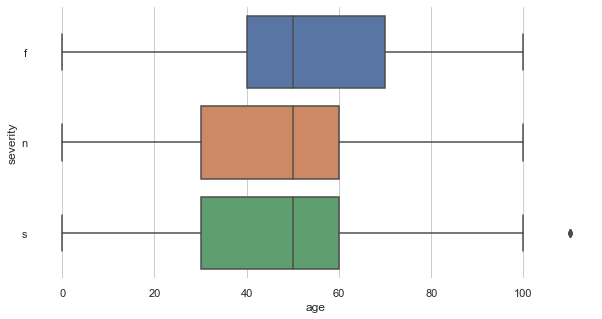

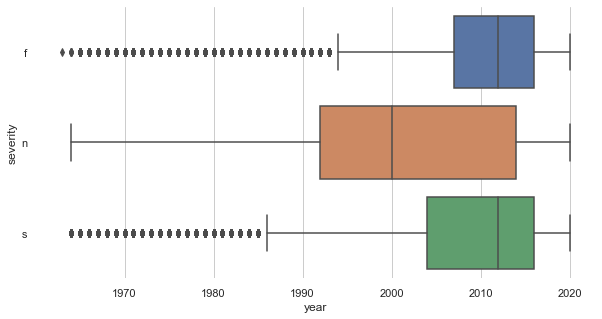

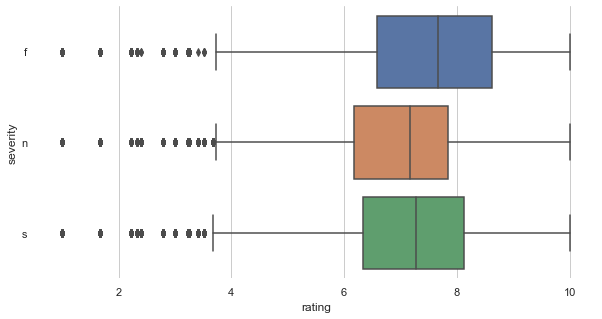

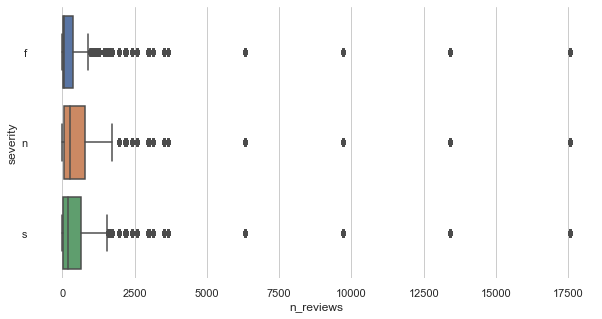

In [141]:
for num in nums:
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(10, 5))
    sns.despine(f, left=True, bottom=True)
    sns.boxplot(x=X[num].values, y=y, ax = ax)
    plt.xlabel(f'{num}')
    plt.show()
    f.savefig(f'sampled_box_{num}_severity.pdf');

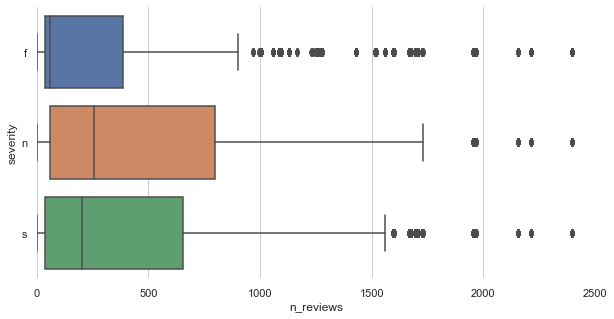

In [145]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.boxplot(x=X_us['n_reviews'].values, y=y_us, ax = ax)
plt.xlabel('n_reviews')
plt.xlim([0, 2500])
plt.show()
f.savefig('sampled_box_n_reviews_severity.pdf');

In [232]:
cats

['category', 'gender', 'age', 'sender', 'is_consumer', 'is_hcp', 'drug']

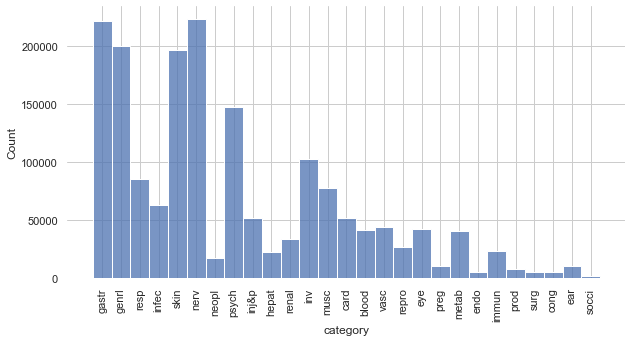

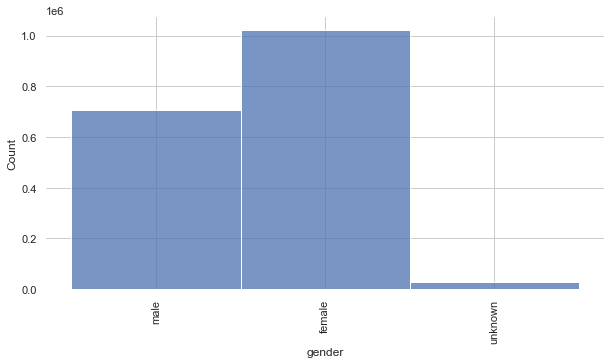

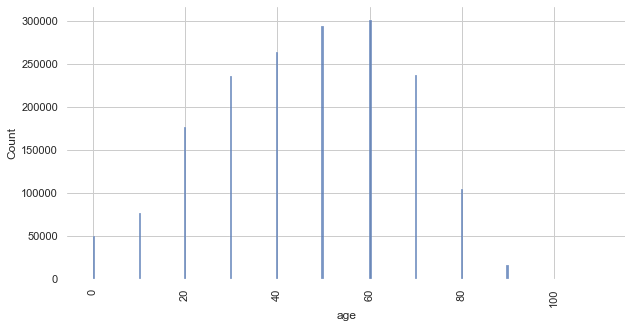

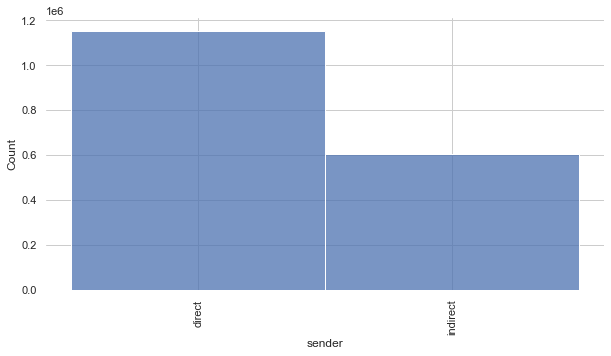

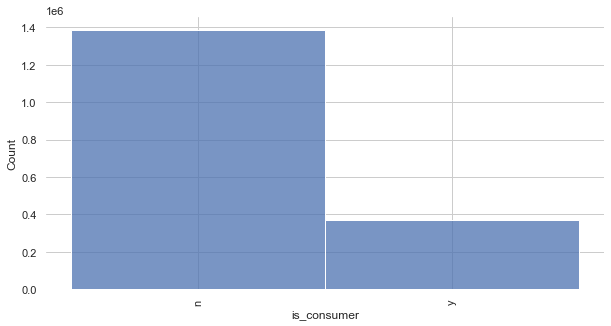

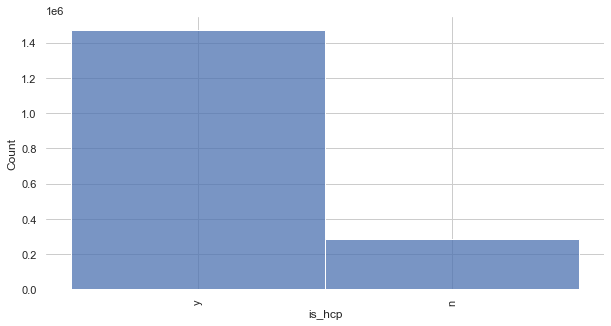

In [148]:
for cat in cats:
    f, ax = plt.subplots(figsize=(10, 5))
    sns.despine(f, left=True, bottom=True)
    sns.histplot(X[cat], ax = ax)
    plt.xticks(rotation = 90)
    f.savefig(f'sampled_{cat}_hist.pdf')
    plt.show()

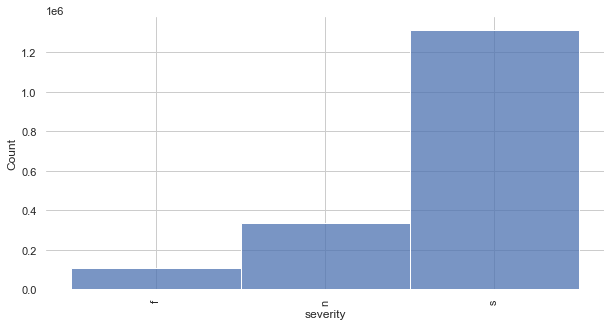

In [149]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f, left=True, bottom=True)
sns.histplot(y, ax = ax)
plt.xticks(rotation = 90)
f.savefig('sampled_severity_hist.pdf')
plt.show()

In [73]:
# X_us.to_csv('undersampled_X.csv')
# y_us.to_csv('undersampled_y.csv')

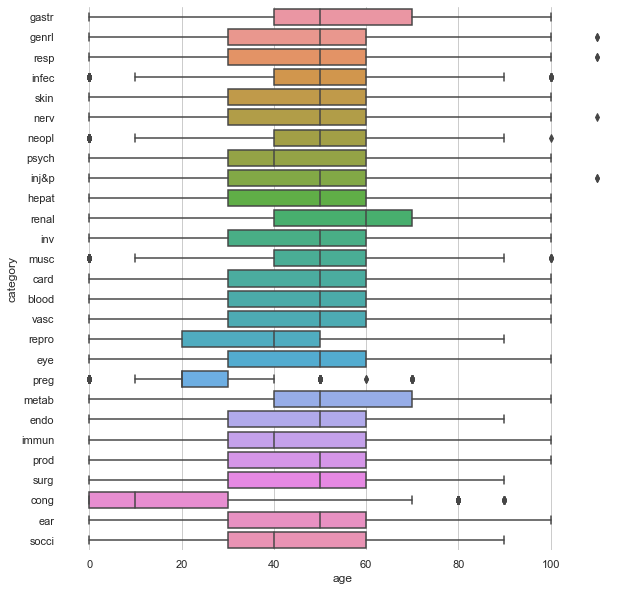

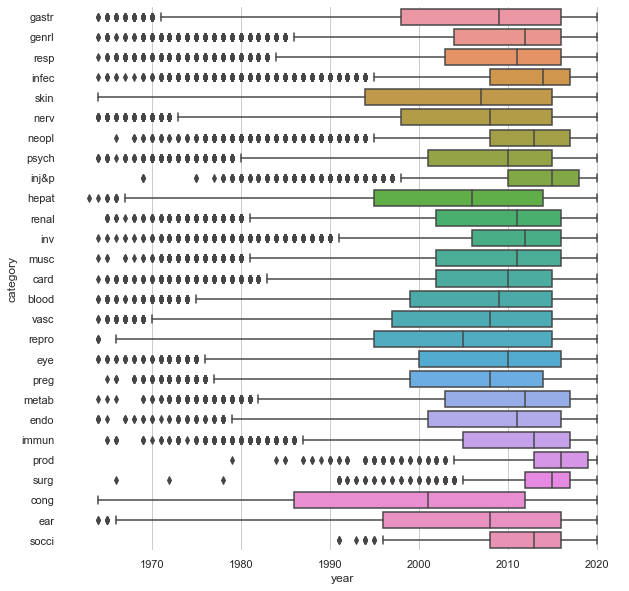

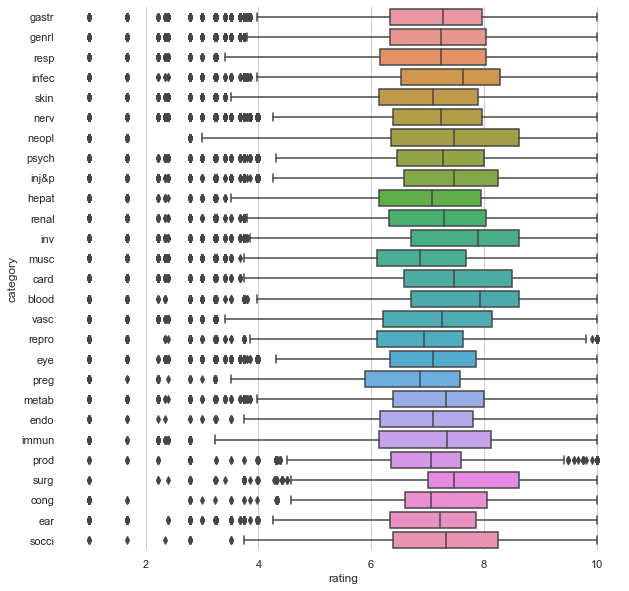

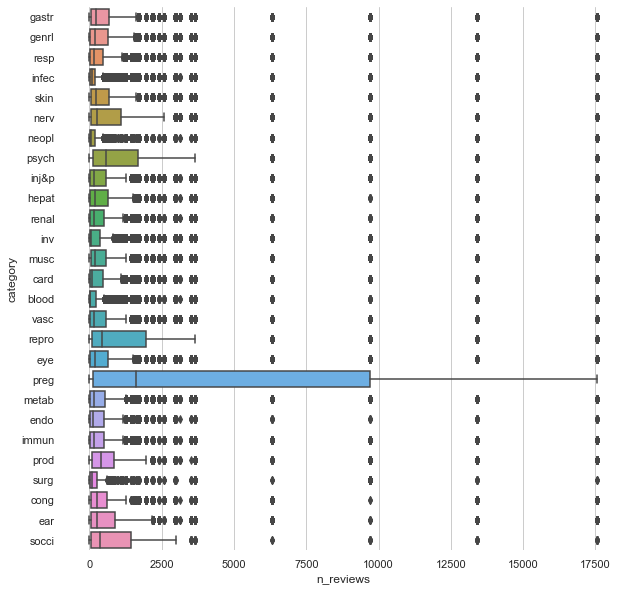

In [150]:
for num in nums:
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(10, 10))
    sns.despine(f, left=True, bottom=True)
    sns.boxplot(x=X[num].values, y=X.category, ax = ax)
    plt.xlabel(f'{num}')
    plt.show()
    f.savefig(f'sampled_box_{num}_category.pdf');

In [80]:
# baseline accuracy
y_test.value_counts(normalize = True)

s    0.747898
n    0.191680
f    0.060423
Name: severity, dtype: float64

In [47]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

In [48]:
# make custom stopwords list for cvec and tvec
# appeared top when trialing but meaningless
cvec = CountVectorizer(stop_words = 'english')
stopwords = list(cvec.get_stop_words())
stopwords.extend(['nan', 'listed', 'othe', 've', 'mg', 'like',
                  'just', 'did', 'don', 'receptor'])

# create count vectorizer for condition column
cvec_condition = CountVectorizer(stop_words = stopwords,
                       max_features = 10000,
                       strip_accents = 'unicode',
                       lowercase = True,
                       decode_error = 'replace',
                       ngram_range = (2, 2),
                       min_df = 0.02)

# create count vectorizer for side_effect column
cvec_se = CountVectorizer(stop_words = stopwords,
                       max_features = 10000,
                       strip_accents = 'unicode',
                       lowercase = True,
                       decode_error = 'replace',
                       ngram_range = (2, 2),
                       min_df = 0.001)

# create count vectorizer for target column
cvec_target = CountVectorizer(stop_words = stopwords,
                       max_features = 10000,
                       strip_accents = 'unicode',
                       lowercase = True,
                       decode_error = 'replace',
                       ngram_range = (2, 2),
                       min_df = 0.001)


# # create tfidf vectorizer for review column
# tvec_review = TfidfVectorizer(stop_words = stopwords,
#                        max_features = 10000,
#                        norm = 'l2', 
#                        strip_accents = 'unicode',
#                        lowercase = True,
#                        decode_error = 'replace',
#                        ngram_range = (2, 2),
#                        min_df = 0.4,
#                        max_df = 0.9)

# create onehotencoder for all categorical columns
one_hot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# create scaler 
scaler = MinMaxScaler()

In [84]:
# db_id not needed for modelling
# X.drop(columns = 'db_id', inplace = True)
X_train.columns

Index(['side_effect', 'category', 'gender', 'age', 'year', 'sender',
       'is_consumer', 'is_hcp', 'target', 'condition', 'rating', 'n_reviews'],
      dtype='object')

In [51]:
# create column transformer
col_trans = ColumnTransformer([('categories', one_hot, cats),
                               ('side_effects', cvec_se, 'side_effect'),
                               ('conditions', cvec_condition, 'condition'),
                               ('targets', cvec_target, 'target')
                               #('reviews', tvec_review, 'review')
                              ],
                              remainder = 'passthrough',
                              sparse_threshold = 0)

In [52]:
# make pipeline for just preprocessing
# make new one with model and grid search after trialing different models

pipe = Pipeline(steps=[('coltrans', col_trans),
                       ('scaler', scaler)])

In [87]:
# diplay pipeline
from sklearn import set_config
set_config(display='diagram')   
pipe

Pipeline(steps=[('coltrans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('categories',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['category', 'gender', 'age',
                                                   'sender', 'is_consumer',
                                                   'is_hcp']),
                                                 ('side_effects',
                                                  CountVectorizer(decode_error='replace',
                                                                  max_features=10000,
                                                                  min_df=0.01,
                                                                  ngram_range=(2,
                                                                               2),
                                                                  stop_words=['inc...
                                                                  min_df=0.001,
                                                                  ngram_range=(2,
                                                                               2),
                                                                  stop_words=['inc',
                                                                              'nobody',
                                                                              'part',
                                                                              'thereupon',
                                                                              'whereby',
                                                                              'bottom',
                                                                              'whereupon',
                                                                              'these',
                                                                              'by',
                                                                              'thence',
                                                                              'else',
                                                                              'herself',
                                                                              'afterwards',
                                                                              'hence',
                                                                              'bill',
                                                                              'if',
                                                                              'against',
                                                                              'a',
                                                                              'and',
                                                                              'where',
                                                                              're',
                                                                              'you',
                                                                              'namely',
                                                                              'seeming',
                                                                              'those',
                                                                              'off',
                                                                              'via',
                                                                              'other',
                                                                              'anywhere',
                                                                              'cannot', ...],
    

In [2]:
import joblib

In [54]:
# try pipeline with dask

with joblib.parallel_backend('dask'):
    # fit transform X_train
    X_train_processed = pipe.fit_transform(X_train)

In [55]:
X_train_processed = pd.DataFrame(X_train_processed, columns = pipe.named_steps['coltrans'].get_feature_names())

In [56]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254541 entries, 0 to 254540
Columns: 1565 entries, categories__x0_blood to n_reviews
dtypes: float64(1565)
memory usage: 3.0 GB


In [57]:
X_train_processed.head()

,categories__x0_blood,categories__x0_card,categories__x0_cong,categories__x0_ear,categories__x0_endo,categories__x0_eye,categories__x0_gastr,categories__x0_genrl,categories__x0_hepat,categories__x0_immun,...,targets__vesicular protein,targets__virus type,targets__vitamin epoxide,targets__voltage dependent,targets__voltage gated,targets__xanthine dehydrogenase,targets__xylose isomerase,year,rating,n_reviews
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.929825,0.814081,0.005758
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.964912,0.841868,0.096625
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.771930,0.597935,0.023201
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.771930,0.741742,0.004218
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000,0.0,0.0,0.0,0.912281,0.806100,0.002907


In [61]:
[col for col in X_train_processed.columns if 'side_effects' in col]

['side_effects__abdominal discomfort',
 'side_effects__abdominal distension',
 'side_effects__abdominal pain',
 'side_effects__abnormal dreams',
 'side_effects__acute hepatic',
 'side_effects__acute kidney',
 'side_effects__alanine aminotransferase',
 'side_effects__aminotransferase increased',
 'side_effects__anaphylactic reaction',
 'side_effects__antipsychotic drug',
 'side_effects__aplastic anaemia',
 'side_effects__application site',
 'side_effects__arteriosclerosis coronary',
 'side_effects__atrial fibrillation',
 'side_effects__balance disorder',
 'side_effects__blood cell',
 'side_effects__blood pressure',
 'side_effects__burning sensation',
 'side_effects__cardiac arrest',
 'side_effects__cardiac failure',
 'side_effects__cell count',
 'side_effects__cerebral haemorrhage',
 'side_effects__cerebrovascular accident',
 'side_effects__chest discomfort',
 'side_effects__chest pain',
 'side_effects__chronic obstructive',
 'side_effects__circulatory collapse',
 'side_effects__clonic 

In [62]:
 # transform X_test
with joblib.parallel_backend('dask'):
    X_test_processed = pipe.transform(X_test)

In [63]:
X_test_processed = pd.DataFrame(X_test_processed, columns = pipe.named_steps['coltrans'].get_feature_names())
X_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351044 entries, 0 to 351043
Columns: 1565 entries, categories__x0_blood to n_reviews
dtypes: float64(1565)
memory usage: 4.1 GB


In [64]:
X_test_processed.shape, y_test.shape

((351044, 1565), (351044,))

In [65]:
X_train_processed.shape, y_train.shape

((254541, 1565), (254541,))

In [66]:
# X_train_processed.to_csv('X_train_processed_2.csv', index = False)
# X_test_processed.to_csv('X_test_processed_2.csv', index = False)
# y_train.to_csv('y_train_2.csv', index = False)
# y_test.to_csv('y_test_2.csv', index = False)

In [31]:
X_train_processed = pd.read_csv('X_train_processed_2.csv')
X_test_processed = pd.read_csv('X_test_processed_2.csv')
y_train = pd.read_csv('y_train_2.csv')
y_test = pd.read_csv('y_test_2.csv')

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [72]:
lr = LogisticRegression(max_iter = 100000)
lr.fit(X_train_processed, y_train)
print(cross_val_score(lr, X_train_processed, y_train, cv = 5).mean())

0.6989758048293094


In [181]:
# create logistic regression model
lr = LogisticRegression(max_iter = 100000)

# create params grid
gs_params = {'penalty': ['l2'],
             'solver': ['saga'],
             'C': np.logspace(-3, 2, 10),
             'multi_class': ['ovr', 'multinomial']}

# create gridsearch
lr_grid = GridSearchCV(lr, gs_params, n_jobs = 2, cv = 3, verbose = 3)
# fit gridsearch on training data
lr_grid.fit(X_train_processed, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 179.4min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 3600.9min finished


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=100000), n_jobs=2,
             param_grid={'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l2'], 'solver': ['saga']},
             verbose=3)

In [182]:
# assign best estimator
best_lr = lr_grid.best_estimator_

In [183]:
joblib.dump(best_lr, 'best_lr.jlib')
# best_lr = joblib.load('best_lr.jlib')

['best_lr.jlib']

In [184]:
# print best params
print('Logreg best parameters: ', lr_grid.best_params_)
# print CV score
print('Best Score: ', lr_grid.best_score_)
# print training score
print('Training Score: ', lr_grid.score(X_train_processed, y_train))
# score best estimator on testing data
print('Test Score: ', lr_grid.score(X_test_processed, y_test))

# create a dataframe to look at the coefficients for class 0
coef_lr = pd.DataFrame({'feature': X_train_processed.columns,
                        'coef': best_lr.coef_[0],
                        'abs_coef': np.abs(best_lr.coef_[0])})

# sort by absolute value of coefficient (magnitude)
coef_lr.sort_values('abs_coef', ascending = False, inplace = True)
coef_lr.head()

Logreg best parameters:  {'C': 100.0, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'saga'}
Best Score:  0.6996476009758742
Training Score:  0.7027512267178961
Test Score:  0.5541014801563336


,feature,coef,abs_coef
594,targets__carbonic anhydrase,-19.865018,19.865018
435,targets__alpha adrenergic,-19.680641,19.680641
1438,targets__subunit alpha,16.989565,16.989565
411,targets__adrenergic alpha,15.575928,15.575928
293,conditions__nsaid induced,-15.241483,15.241483


In [202]:
# joblib.dump(best_lr, 'best_lr.jlib')

['best_lr.jlib']

In [196]:
best_lr.classes_

array(['f', 'n', 's'], dtype=object)

<AxesSubplot:ylabel='feature'>

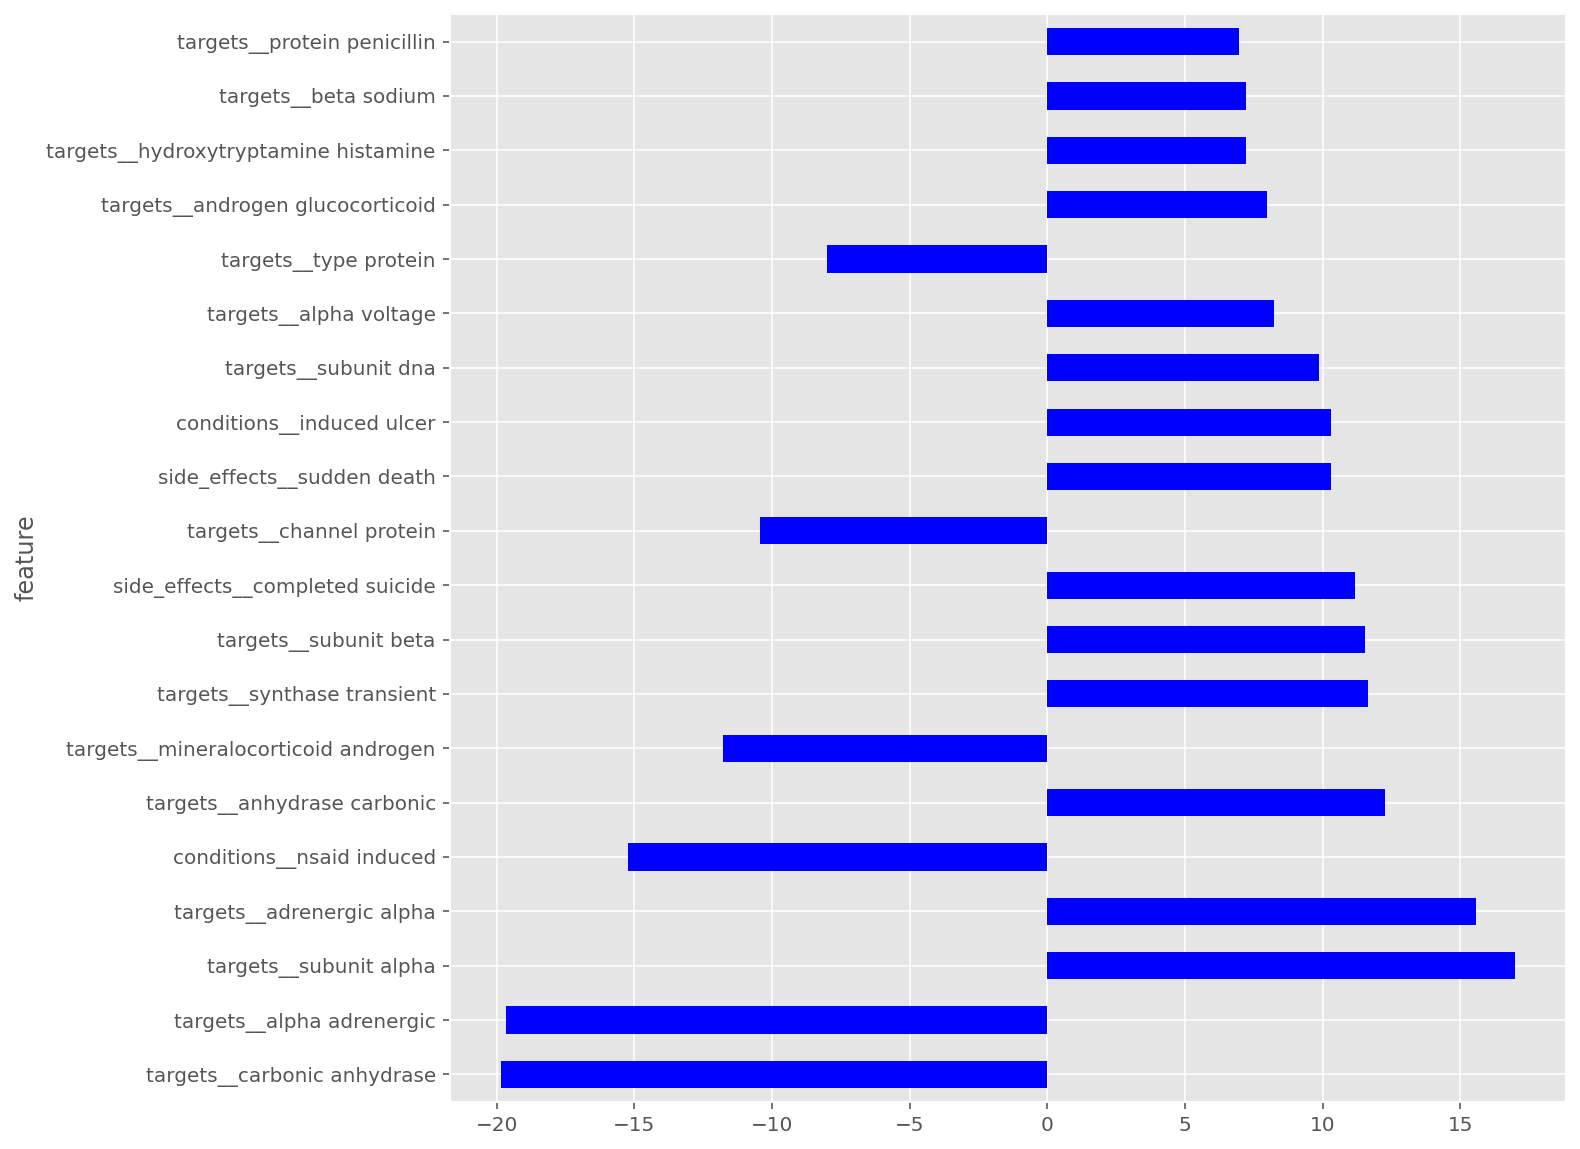

In [199]:
coef_lr.set_index('feature', inplace = True)
coef_lr.coef.head(20).plot(kind = 'barh', figsize = (10,10), color = 'b')

<AxesSubplot:ylabel='feature'>

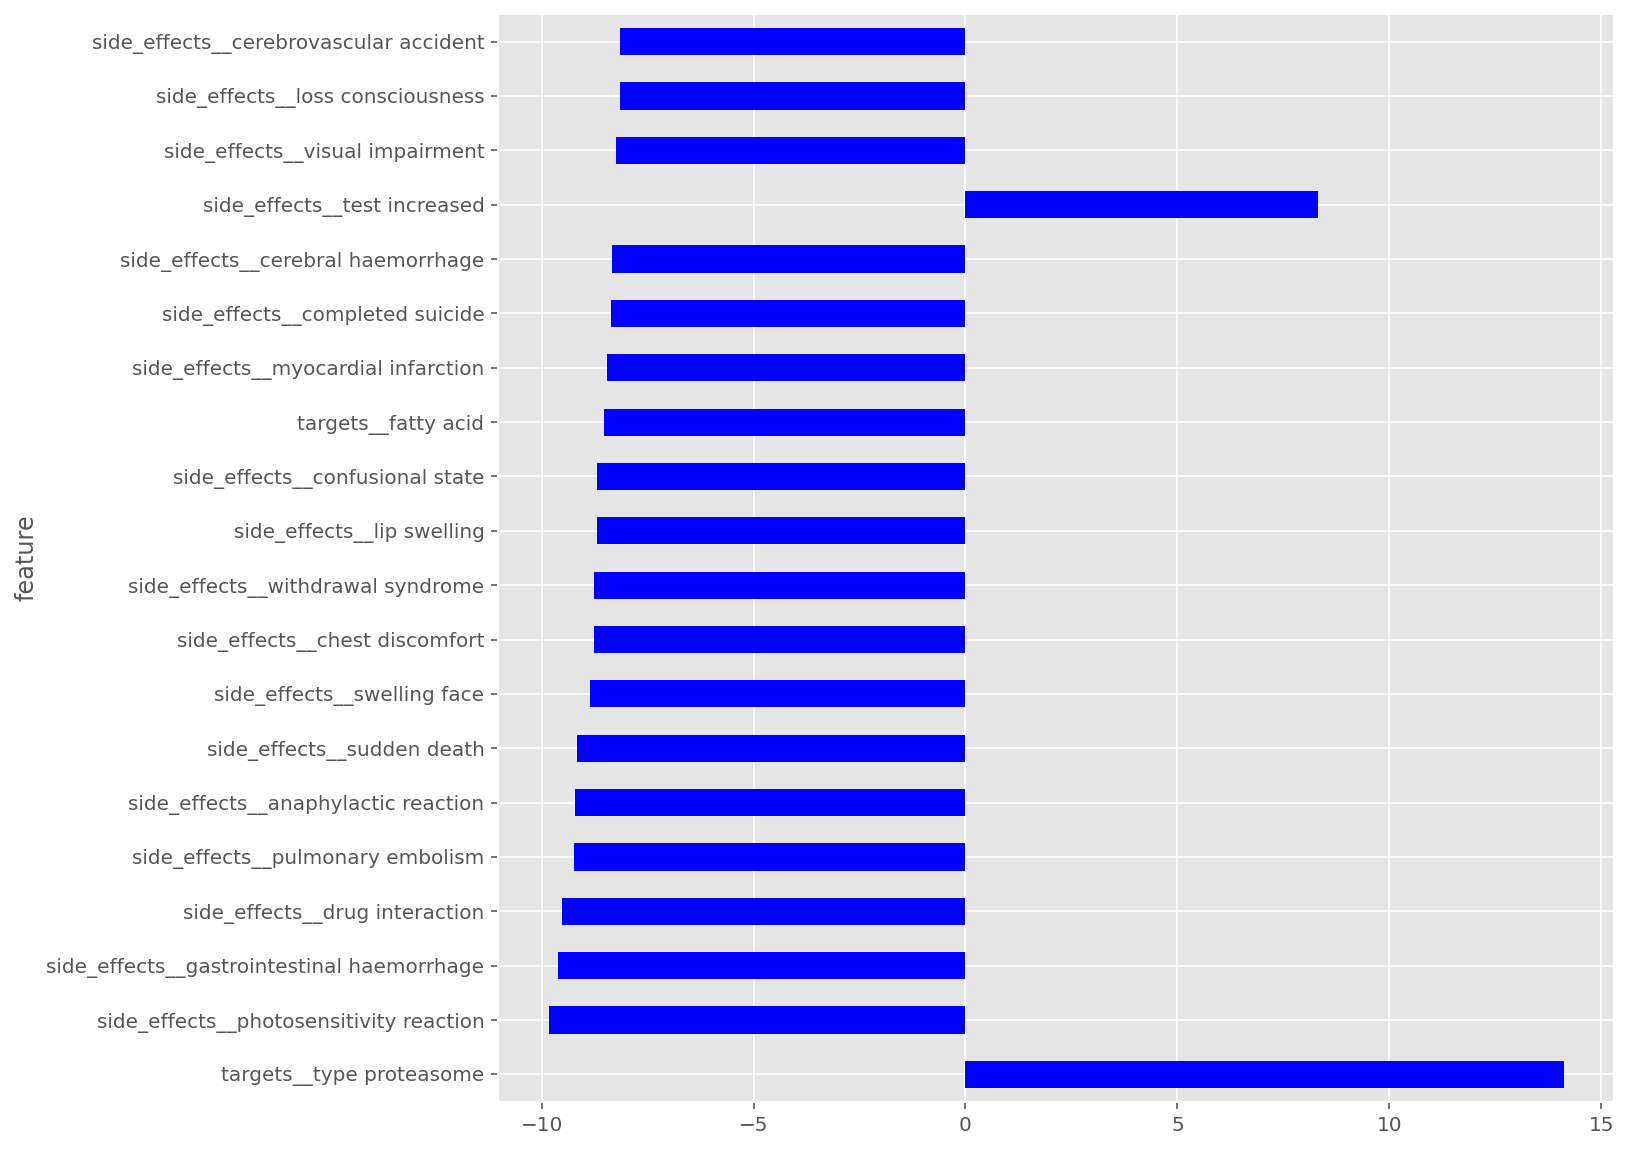

In [200]:
coef_lr_n = pd.DataFrame({'feature': X_train_processed.columns,
                        'coef': best_lr.coef_[1],
                        'abs_coef': np.abs(best_lr.coef_[1])})

# sort by absolute value of coefficient (magnitude)
coef_lr_n.sort_values('abs_coef', ascending = False, inplace = True)
coef_lr_n.set_index('feature', inplace = True)
coef_lr_n.coef.head(20).plot(kind = 'barh', figsize = (10,10), color = 'b')

<AxesSubplot:ylabel='feature'>

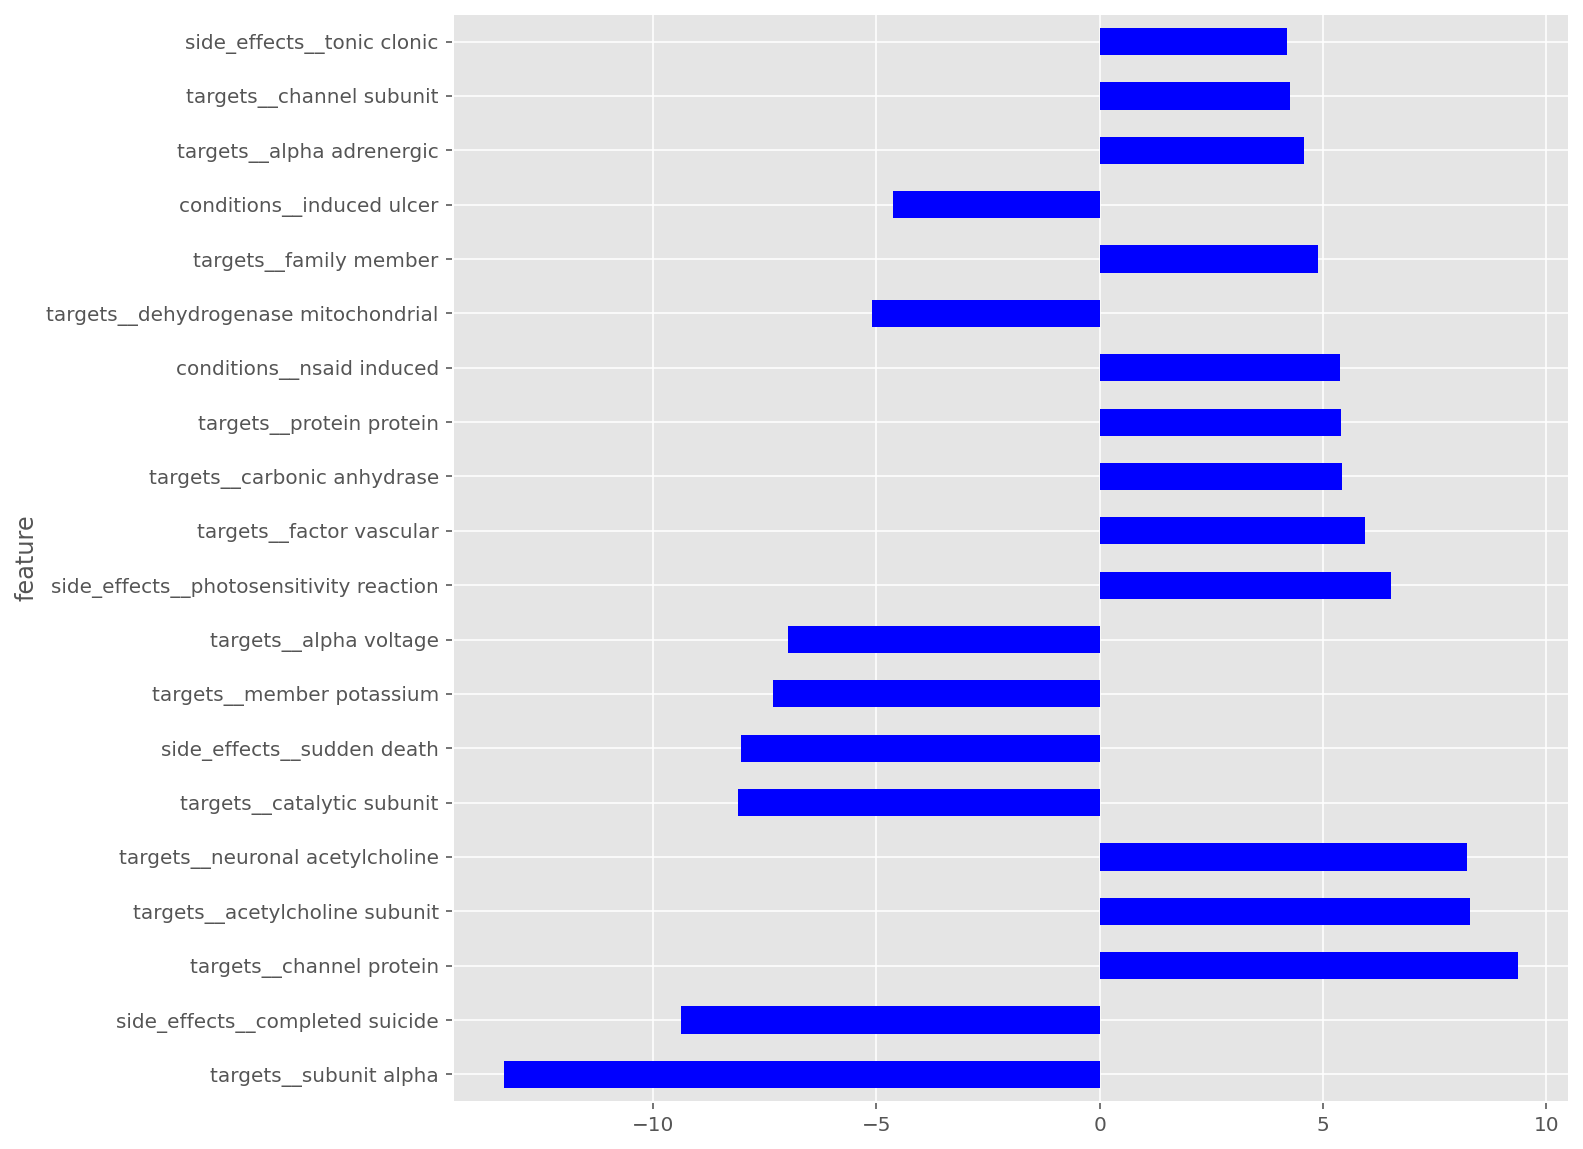

In [201]:
coef_lr_s = pd.DataFrame({'feature': X_train_processed.columns,
                        'coef': best_lr.coef_[2],
                        'abs_coef': np.abs(best_lr.coef_[2])})

# sort by absolute value of coefficient (magnitude)
coef_lr_s.sort_values('abs_coef', ascending = False, inplace = True)
coef_lr_s.set_index('feature', inplace = True)
coef_lr_s.coef.head(20).plot(kind = 'barh', figsize = (10,10), color = 'b')

              precision    recall  f1-score   support

           f       0.78      0.73      0.75     90797
           n       0.86      0.72      0.79    101615
           s       0.47      0.64      0.54     62129

    accuracy                           0.70    254541
   macro avg       0.70      0.70      0.69    254541
weighted avg       0.74      0.70      0.71    254541



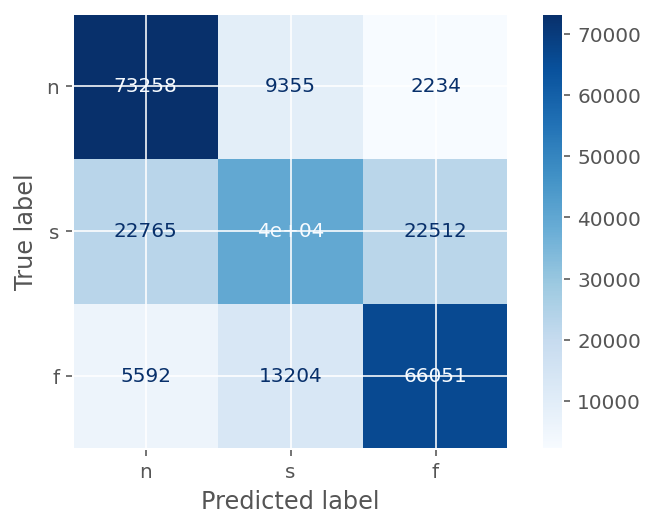

In [185]:
print(classification_report(best_lr.predict(X_train_processed), y_train))
plot_confusion_matrix(best_lr, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

              precision    recall  f1-score   support

           f       0.77      0.18      0.30     89698
           n       0.86      0.44      0.59    130244
           s       0.46      0.92      0.61    131102

    accuracy                           0.55    351044
   macro avg       0.70      0.51      0.50    351044
weighted avg       0.69      0.55      0.52    351044



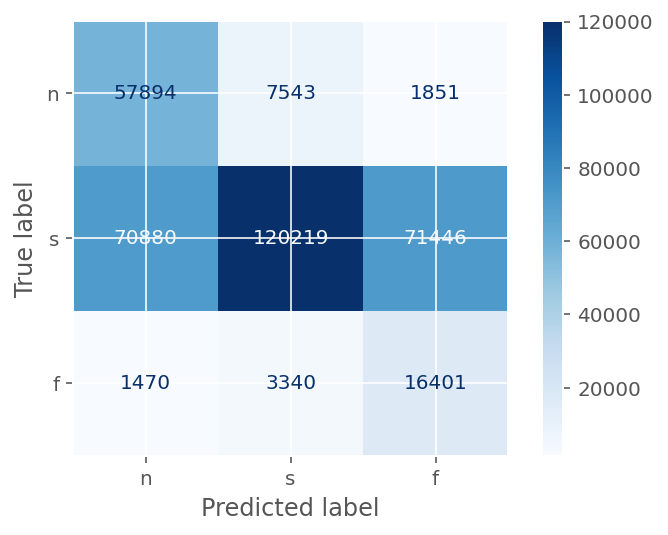

In [186]:
print(classification_report(best_lr.predict(X_test_processed), y_test))
plot_confusion_matrix(best_lr, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

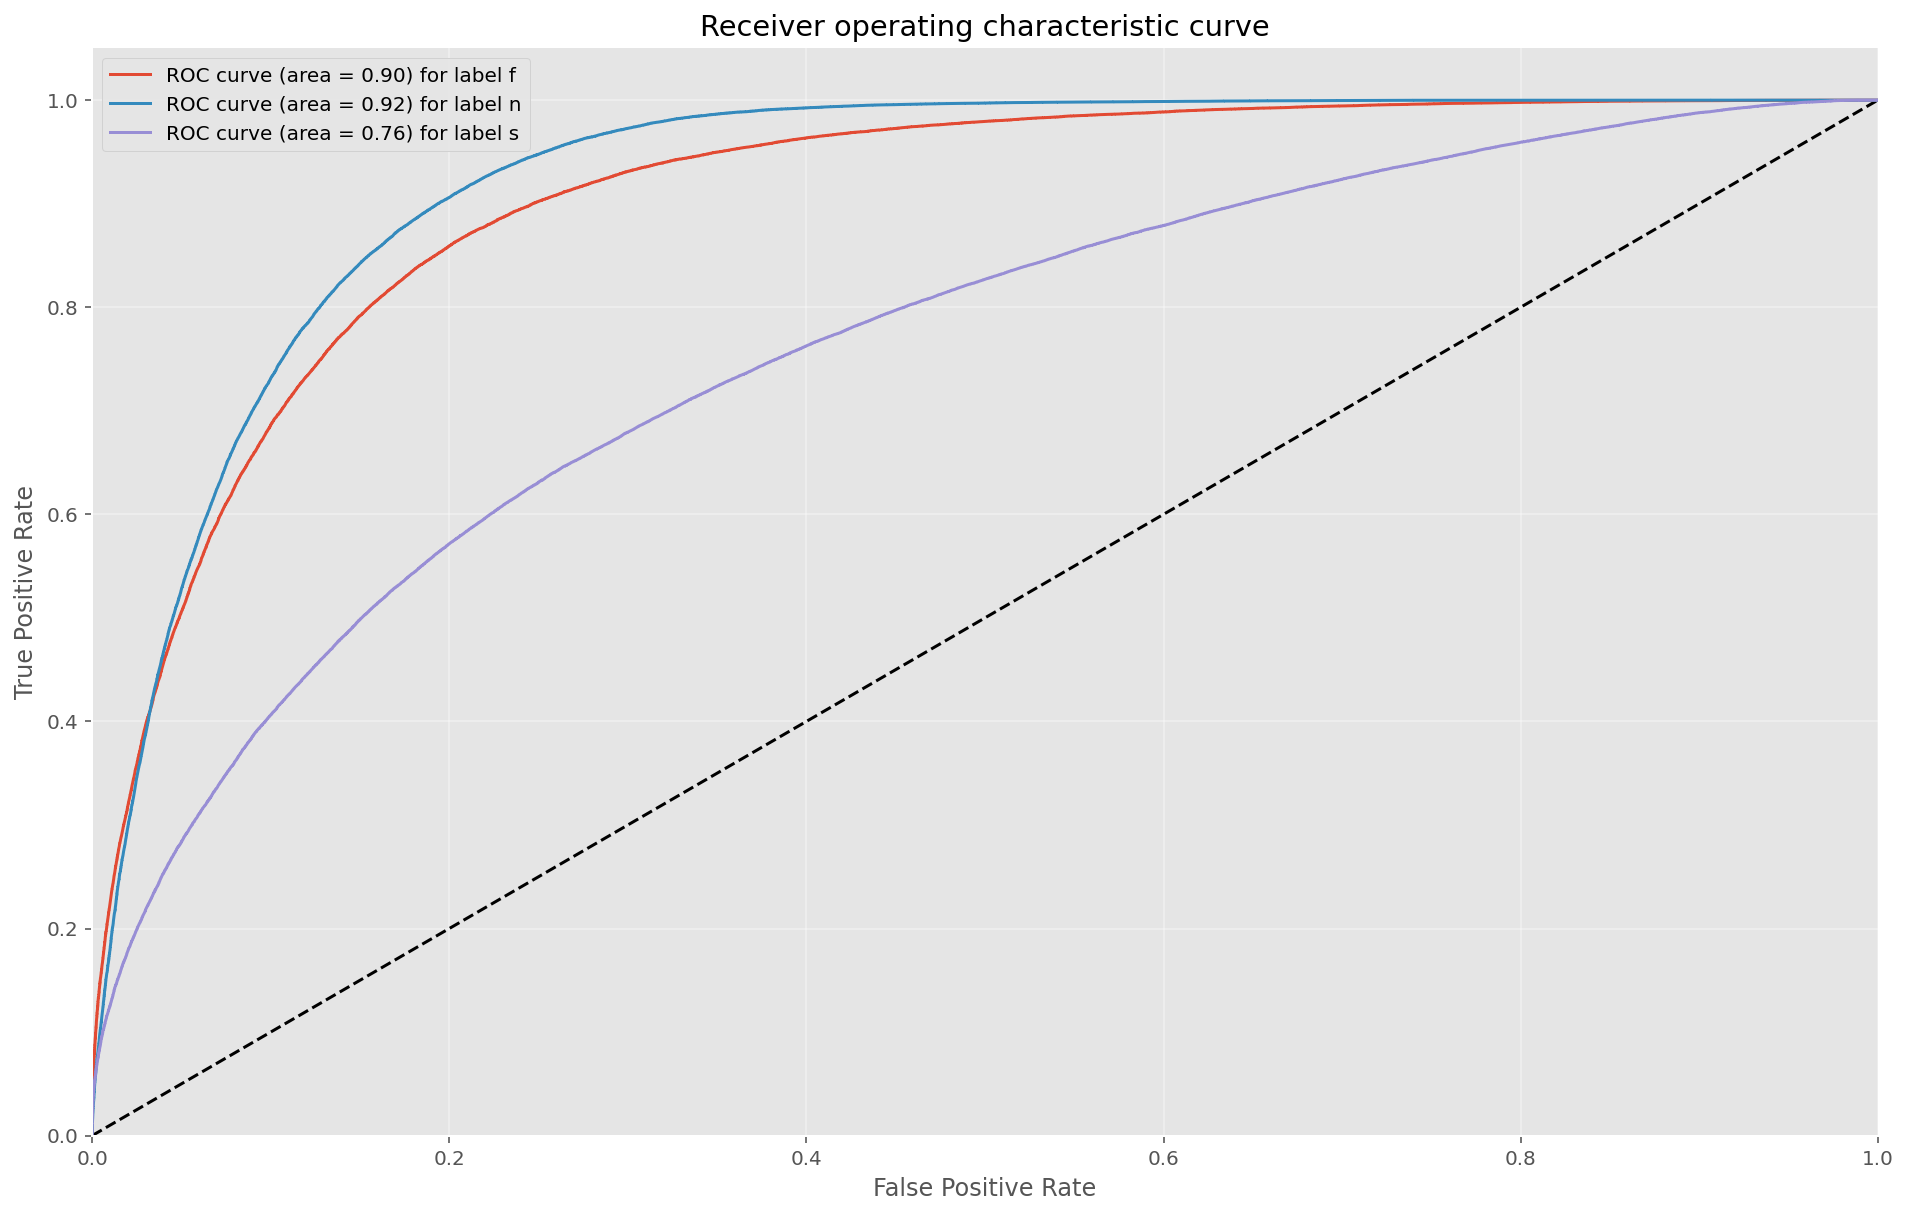

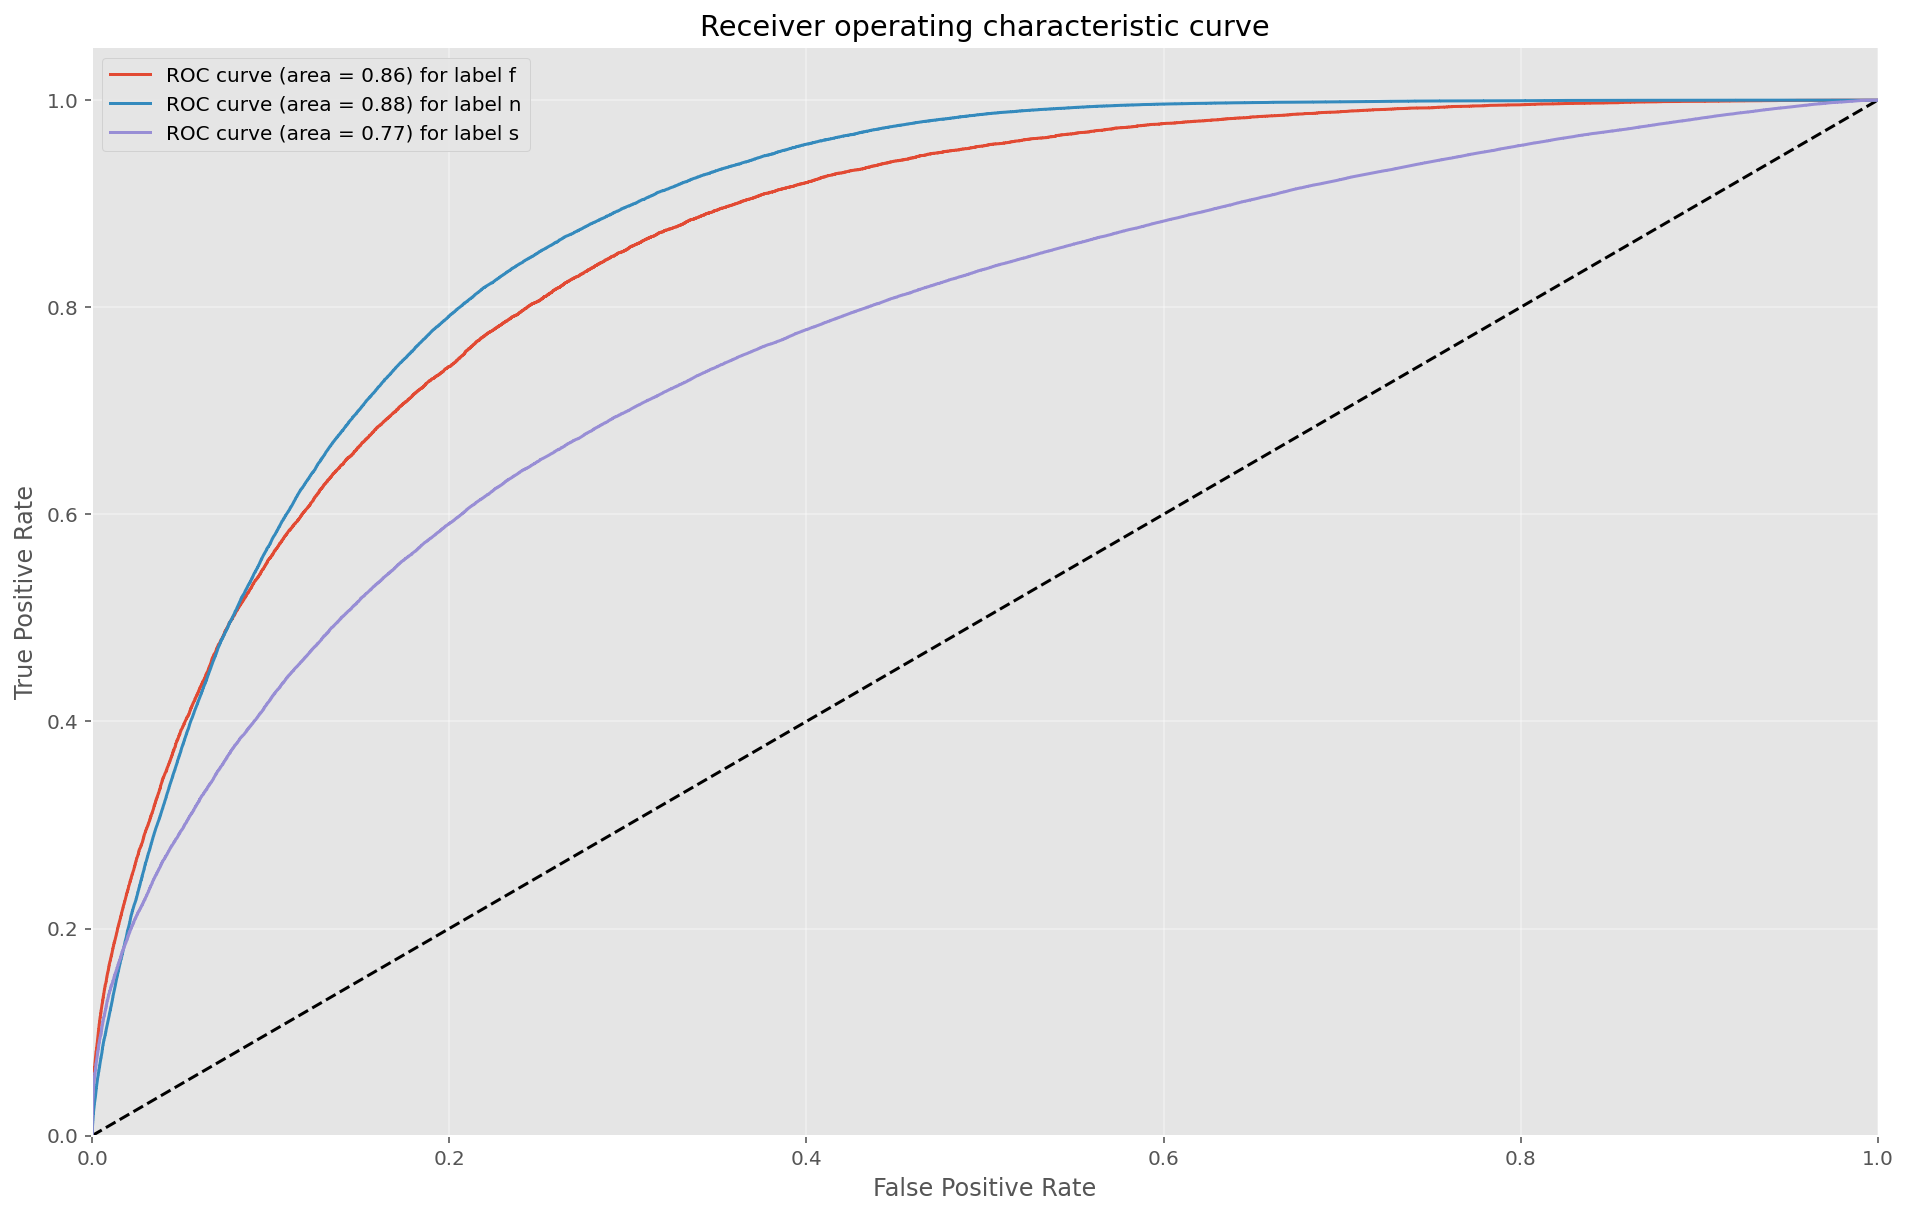

In [187]:
plot_multiclass_roc(best_lr, X_train_processed , y_train, 3, figsize=(16, 10))
plot_multiclass_roc(best_lr, X_test_processed , y_test, 3, figsize=(16, 10))

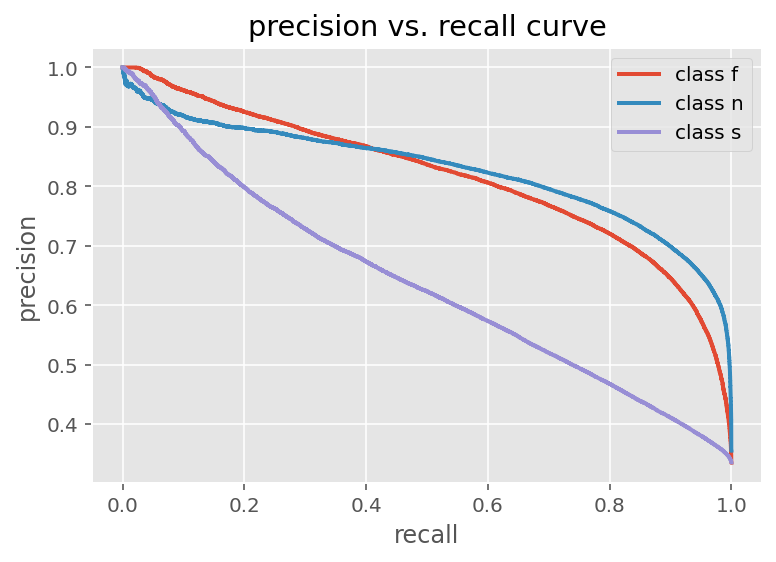

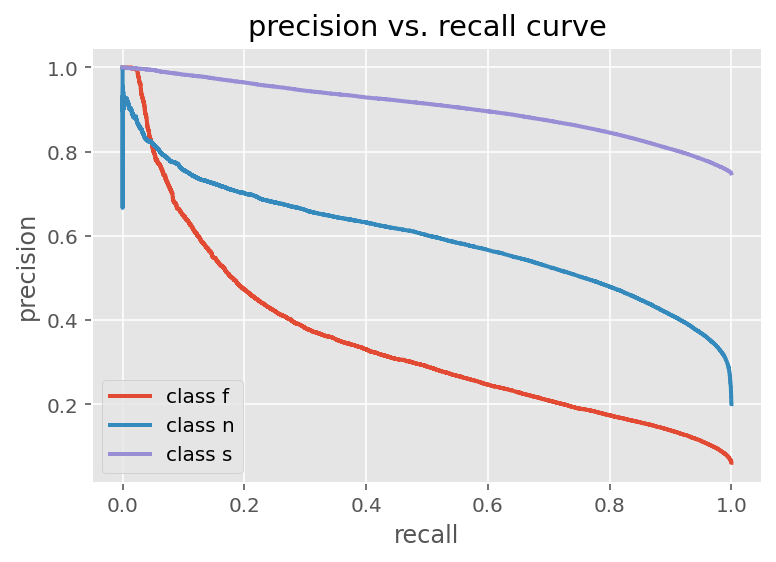

In [188]:
multiclass_precision_recall(best_lr, X_train_processed, y_train)
multiclass_precision_recall(best_lr, X_test_processed, y_test)

##### 

In [32]:
y_train.head()

,severity
0,f
1,f
2,f
3,f
4,f


In [33]:
y_train = np.ravel(y_train)

In [34]:
# random forest

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 15, n_jobs = 2)
rf.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=15, n_jobs=2)

In [36]:
cross_val_score(rf, X_train_processed, y_train, cv=5).mean()

0.6424033865457437

In [35]:
from sklearn.tree import export_graphviz
import graphviz

from ipywidgets import *
from IPython.display import display
from IPython.display import Image

In [44]:
# random forest grid search
rf_params = {'n_estimators': [500, 700],
             'max_depth': range(5, 25, 5),
             'max_features': range(50, 110, 20)}

rf_grid = GridSearchCV(rf, rf_params, cv = 3, n_jobs = 2, verbose = 3)
rf_grid.fit(X_train_processed, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 85.5min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed: 501.0min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(max_depth=15, n_jobs=2),
             n_jobs=2,
             param_grid={'max_depth': range(5, 25, 5),
                         'max_features': range(50, 110, 20),
                         'n_estimators': [500, 700]},
             verbose=3)

In [45]:
# print best score and parameters
print(rf_grid.best_score_)
print(rf_grid.best_params_)

best_rf = rf_grid.best_estimator_

# refit best model, save cross_val_scores then .mean()

0.6929099830675609
{'max_depth': 20, 'max_features': 90, 'n_estimators': 500}


In [89]:
rf_pred_train = best_rf.predict(X_train_processed)
rf_pred_test = best_rf.predict(X_test_processed)

In [52]:
print(best_rf.score(X_train_processed, y_train))
print(best_rf.score(X_test_processed, y_test))

0.7298509866779811
0.5071501008420597


In [83]:
from sklearn.metrics import plot_confusion_matrix, classification_report

              precision    recall  f1-score   support

           f       0.84      0.76      0.80     93952
           n       0.91      0.68      0.78    113079
           s       0.44      0.78      0.56     47510

    accuracy                           0.73    254541
   macro avg       0.73      0.74      0.71    254541
weighted avg       0.80      0.73      0.75    254541



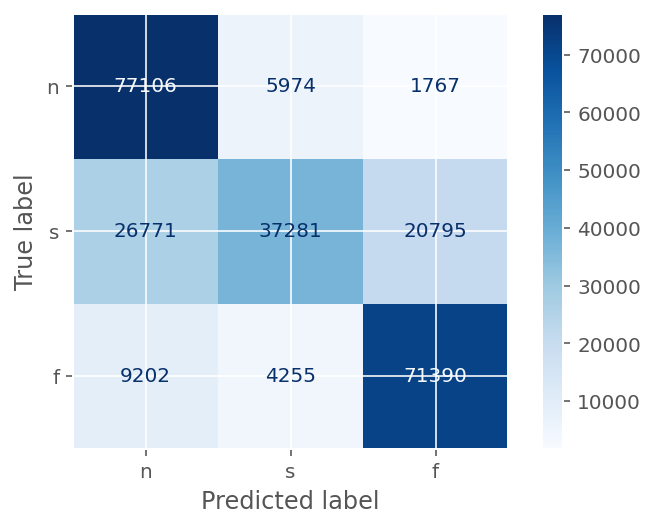

In [90]:
print(classification_report(rf_pred_train, y_train))
plot_confusion_matrix(best_rf, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

              precision    recall  f1-score   support

           f       0.81      0.19      0.30     92636
           n       0.89      0.40      0.55    149943
           s       0.38      0.93      0.54    108465

    accuracy                           0.51    351044
   macro avg       0.70      0.51      0.47    351044
weighted avg       0.71      0.51      0.48    351044



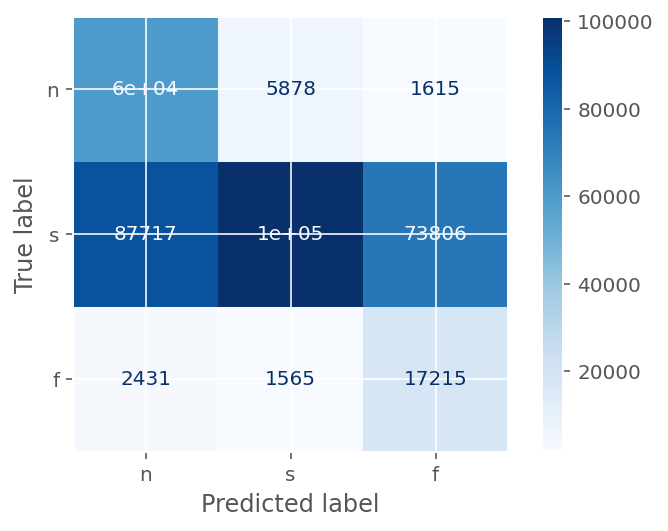

In [91]:
print(classification_report(rf_pred_test, y_test))
plot_confusion_matrix(best_rf, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

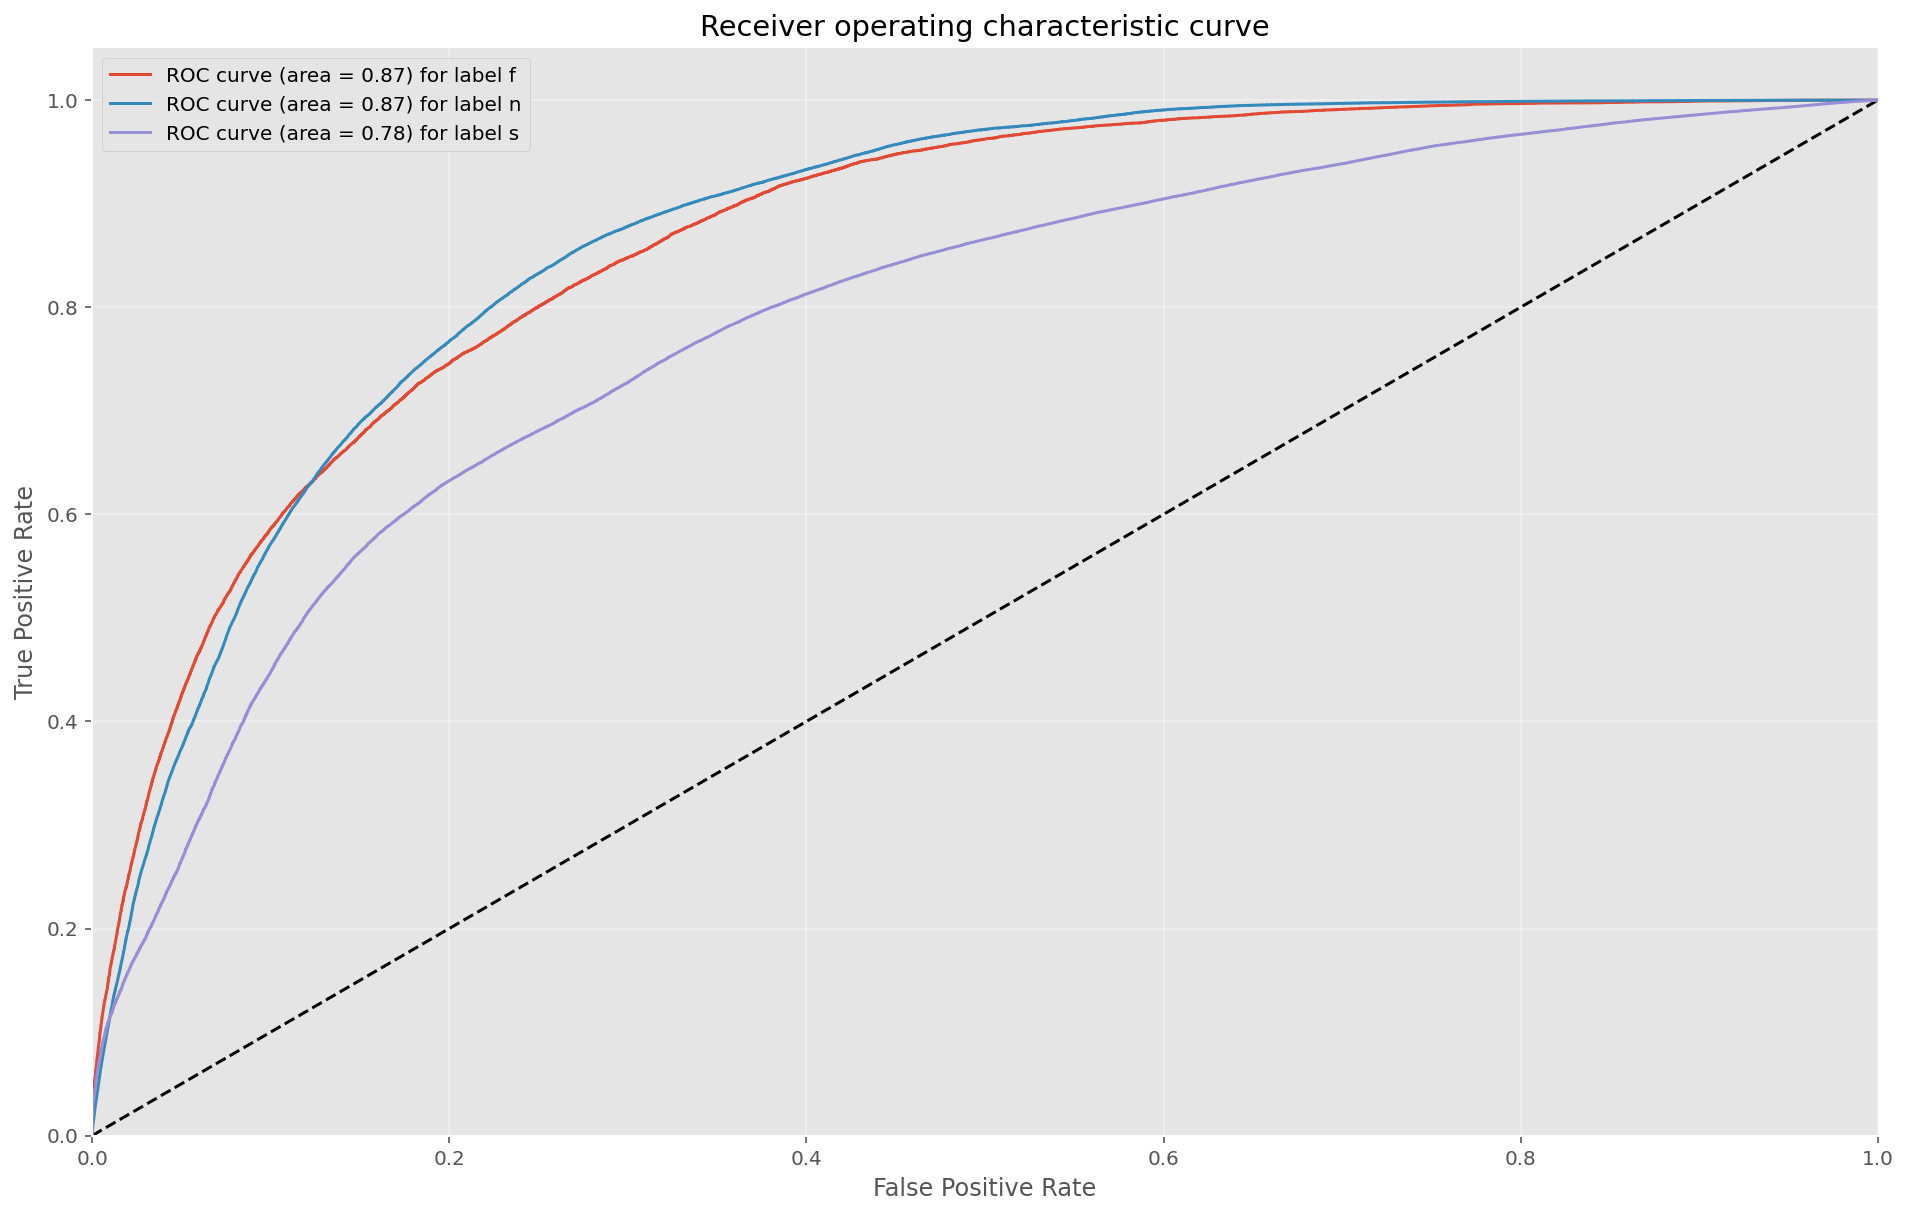

In [120]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i, y in enumerate(clf.classes_):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic curve')
    for i, y in enumerate(clf.classes_):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], y))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(best_rf, X_test_processed , y_test, 3, figsize=(16, 10))

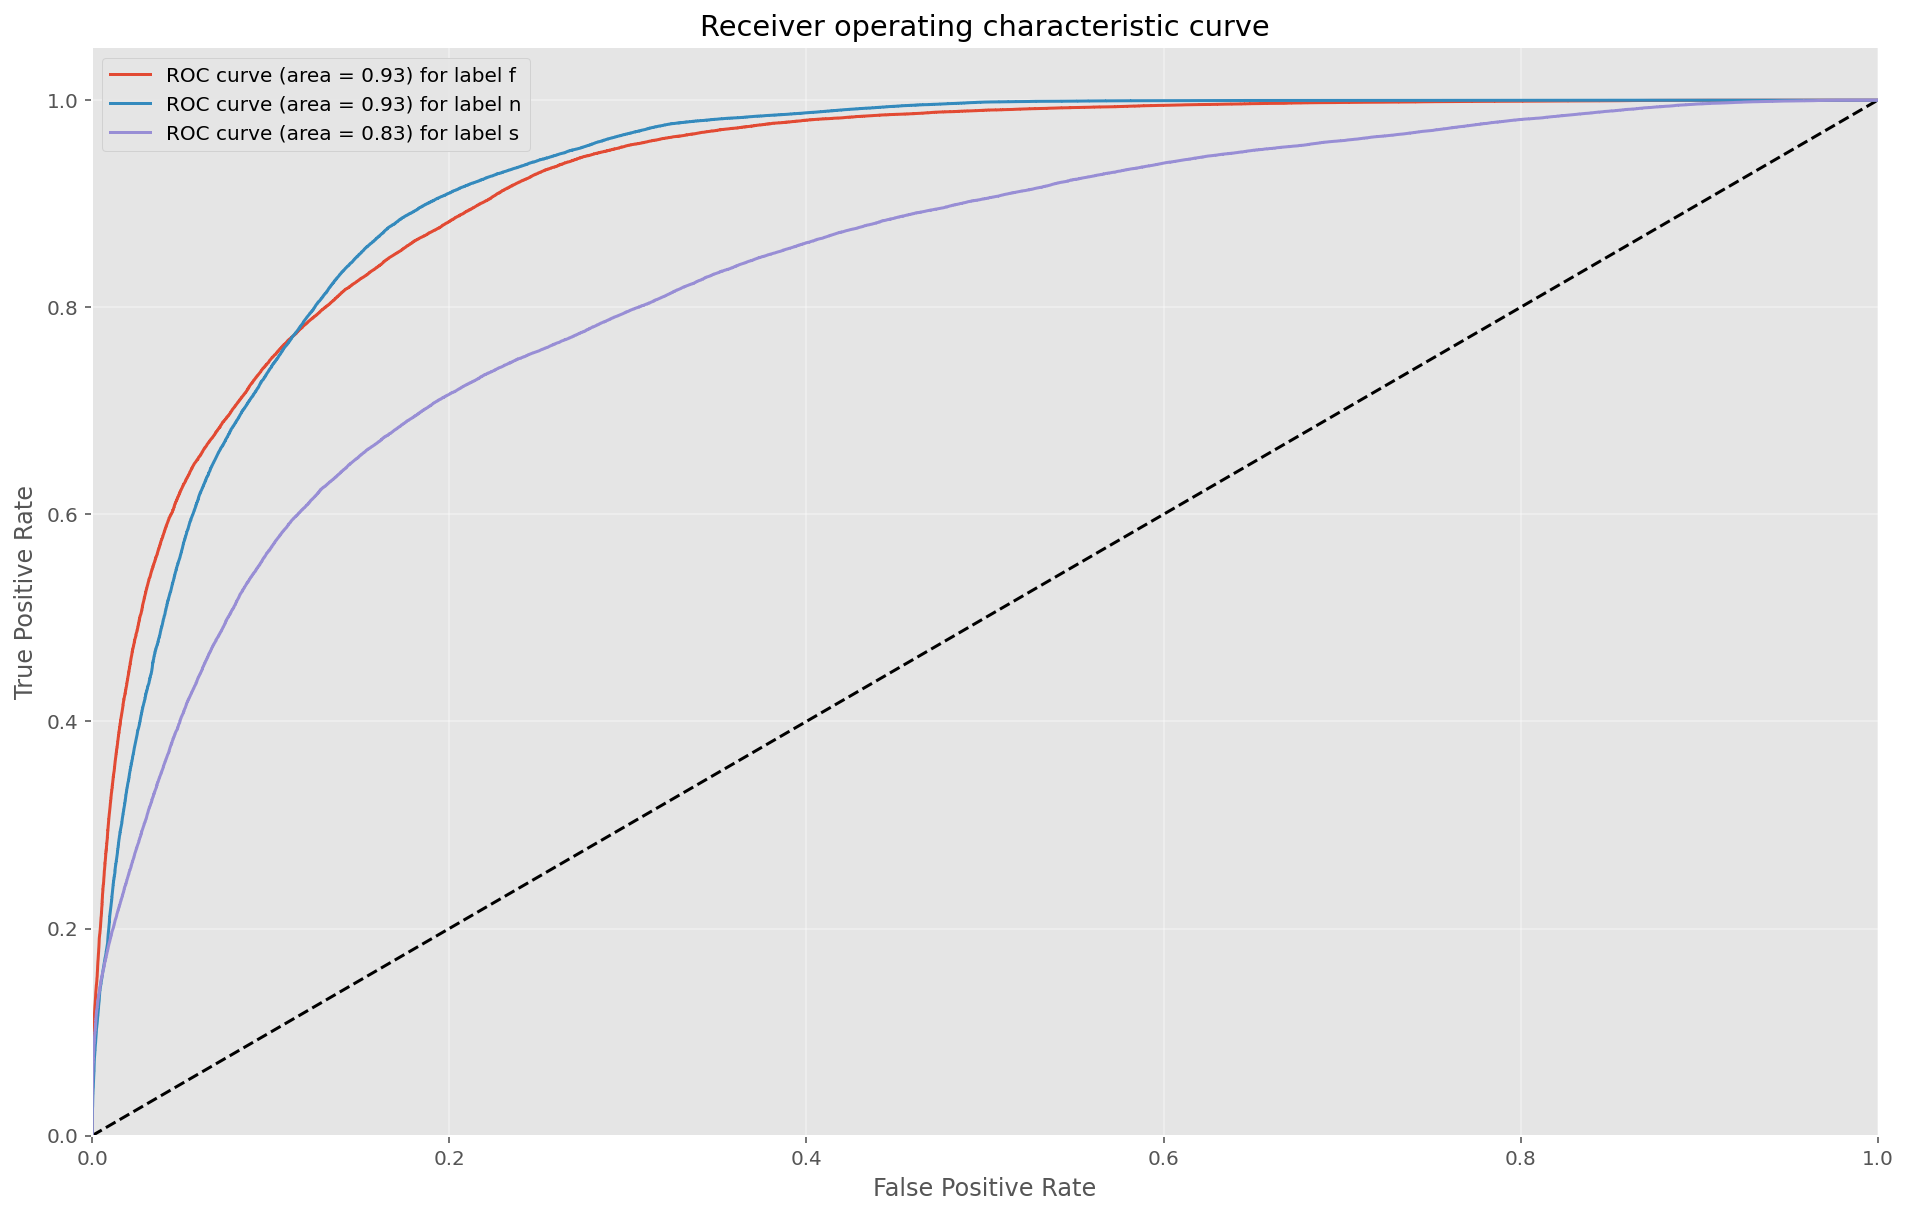

In [148]:
plot_multiclass_roc(best_rf, X_train_processed , y_train, 3, figsize=(16, 10))

In [106]:
best_rf.classes_

array(['f', 'n', 's'], dtype=object)

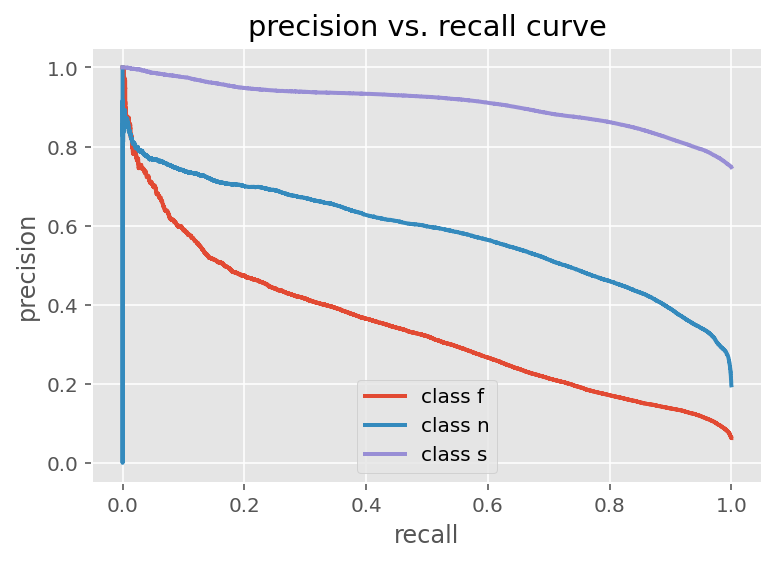

In [139]:
# https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier

from sklearn.metrics import precision_recall_curve
def multiclass_precision_recall(model, X_test, y_test):
    y_score = model.predict_proba(X_test)
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    precision = dict()
    recall = dict()
    for i, y in enumerate(model.classes_):
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i],
                                                            y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(y))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()
multiclass_precision_recall(best_rf, X_test_processed, y_test)

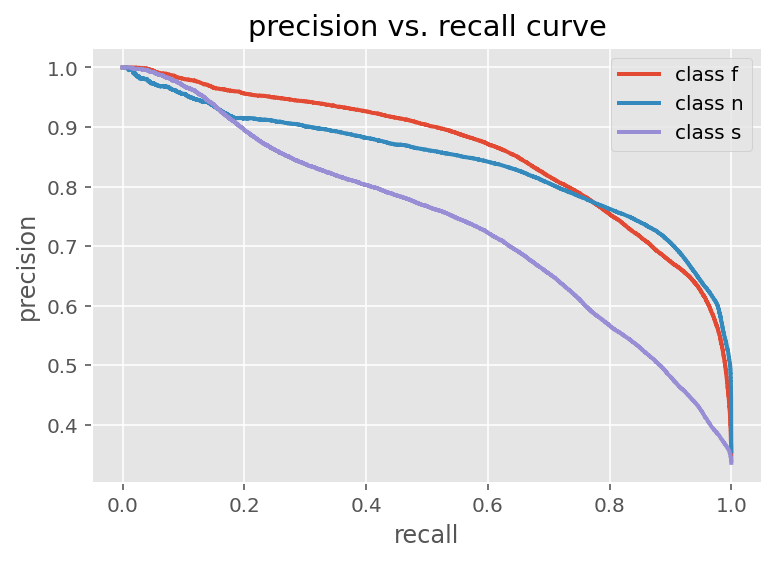

In [149]:
multiclass_precision_recall(best_rf, X_train_processed, y_train)

In [129]:
rf_features = np.mean([
    tree.feature_importances_ for tree in best_rf], axis = 0)
rf_feature_df = pd.DataFrame({'importances': rf_features}, index = X_train_processed.columns)
rf_feature_df.sort_values('importances', ascending = False).head(20)

,importances
categories__x3_direct,0.142584
categories__x3_indirect,0.134702
year,0.105233
categories__x0_skin,0.053637
categories__x4_y,0.018146
categories__x4_n,0.017128
categories__x5_n,0.017071
categories__x0_card,0.014527
categories__x5_y,0.014480
n_reviews,0.013582


<AxesSubplot:>

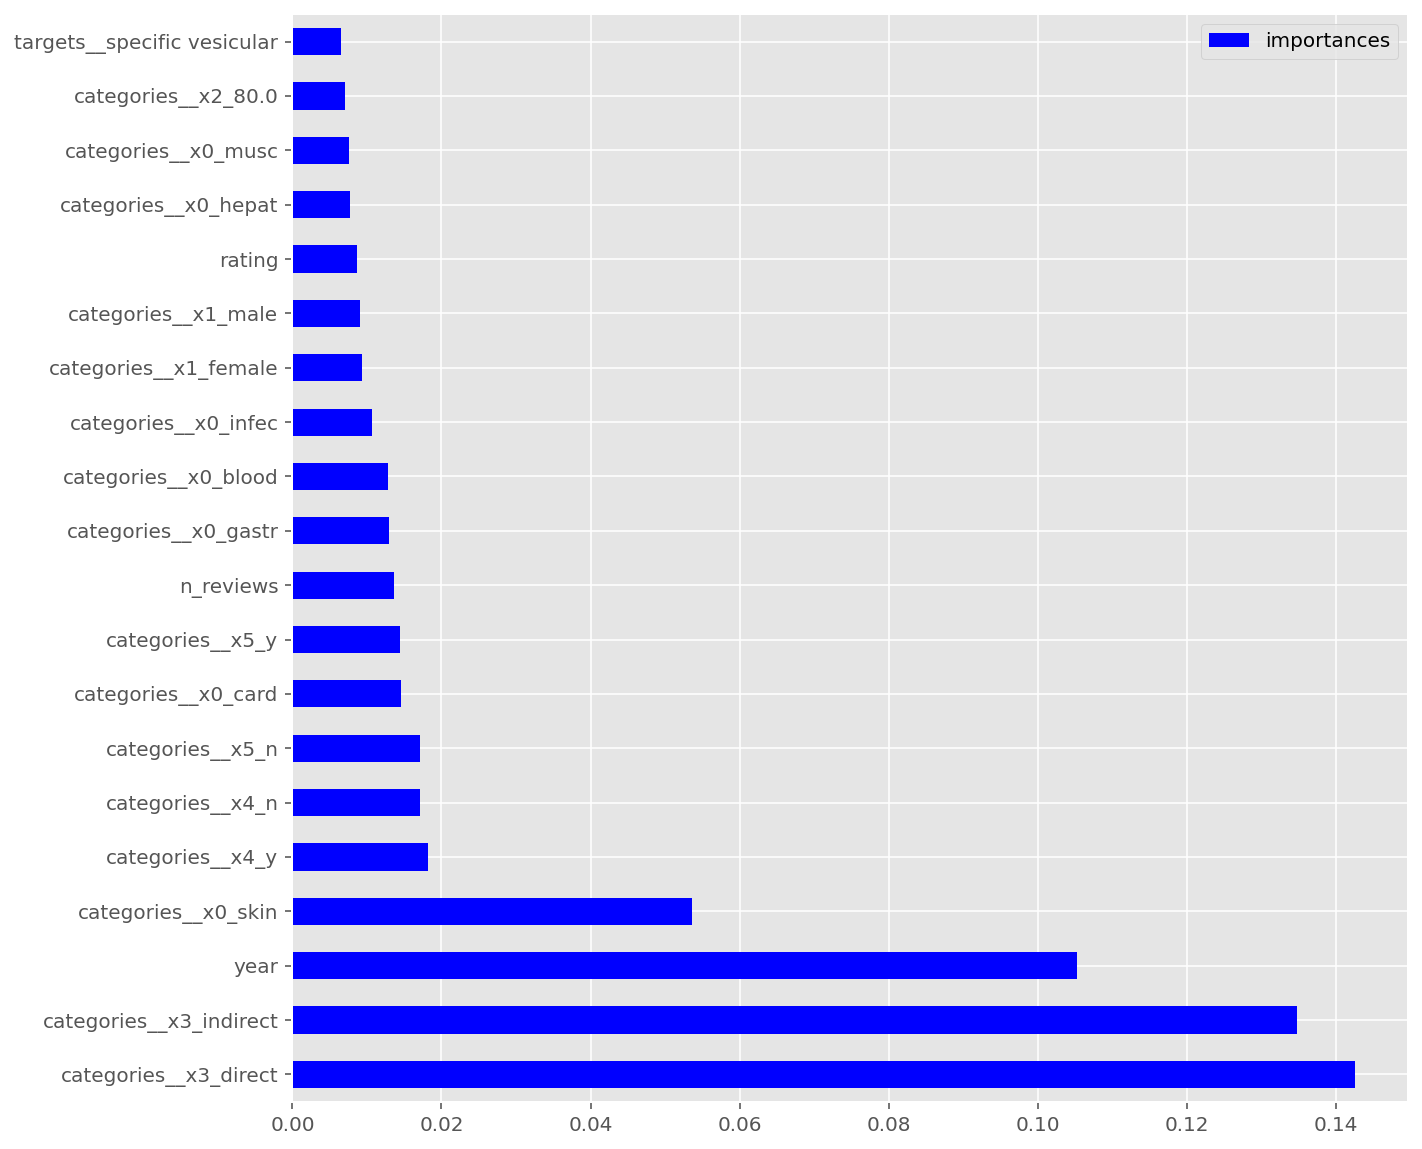

In [131]:
rf_feature_df.sort_values('importances', ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [46]:
import joblib
joblib.dump(best_rf, 'best_rf.jlib')

['best_rf.jlib']

In [47]:
# decision tree depth 5
dtc = DecisionTreeClassifier(max_depth = 5)
dtc.fit(X_train_processed, y_train)
dtc_scores = cross_val_score(dtc, X_train_processed, y_train, cv = 5)
print(dtc_scores.mean())

0.5997029933577653


In [49]:
# then grid search decision tree
# random forest grid search
dtc2 = DecisionTreeClassifier()

dt_params = {'max_depth': range(5, 25, 5),
             'max_features': range(50, 110, 20)}

dt_grid = GridSearchCV(dtc2, dt_params, cv = 5, n_jobs = 2, verbose = 3)
dt_grid.fit(X_train_processed, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  7.1min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 20.0min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'max_depth': range(5, 25, 5),
                         'max_features': range(50, 110, 20)},
             verbose=3)

In [50]:
# print best score and parameters
print(dt_grid.best_score_)
print(dt_grid.best_params_)

best_dt = dt_grid.best_estimator_

# refit best model, save cross_val_scores then .mean()

0.6390836598187961
{'max_depth': 20, 'max_features': 70}


In [51]:
joblib.dump(best_dt, 'best_dt.jlib')

['best_dt.jlib']

In [53]:
print(best_dt.score(X_train_processed, y_train))
print(best_dt.score(X_test_processed, y_test))

0.6216955225287871
0.524116634951744


              precision    recall  f1-score   support

           f       0.66      0.67      0.67     83587
           n       0.71      0.65      0.68     92069
           s       0.50      0.53      0.51     78885

    accuracy                           0.62    254541
   macro avg       0.62      0.62      0.62    254541
weighted avg       0.63      0.62      0.62    254541



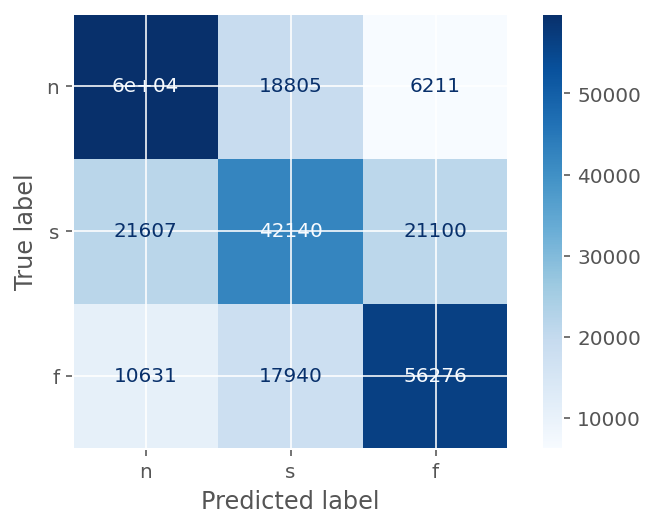

In [92]:
print(classification_report(best_dt.predict(X_train_processed), y_train))
plot_confusion_matrix(best_dt, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

              precision    recall  f1-score   support

           f       0.65      0.16      0.25     88226
           n       0.69      0.39      0.50    118660
           s       0.47      0.86      0.61    144158

    accuracy                           0.52    351044
   macro avg       0.60      0.47      0.45    351044
weighted avg       0.59      0.52      0.48    351044



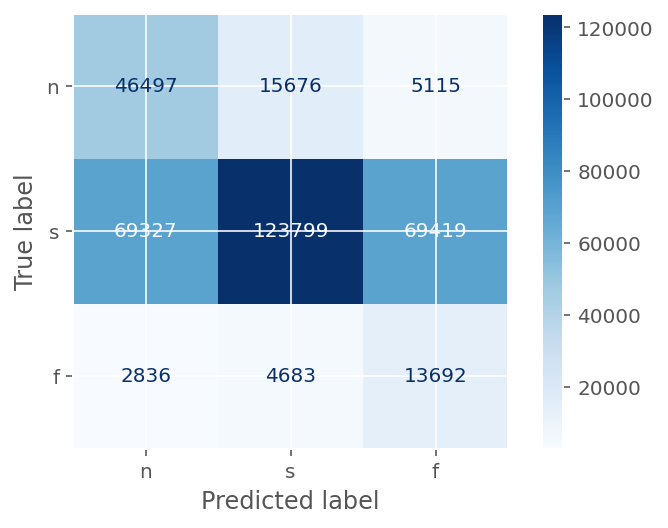

In [93]:
print(classification_report(best_dt.predict(X_test_processed), y_test))
plot_confusion_matrix(best_dt, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

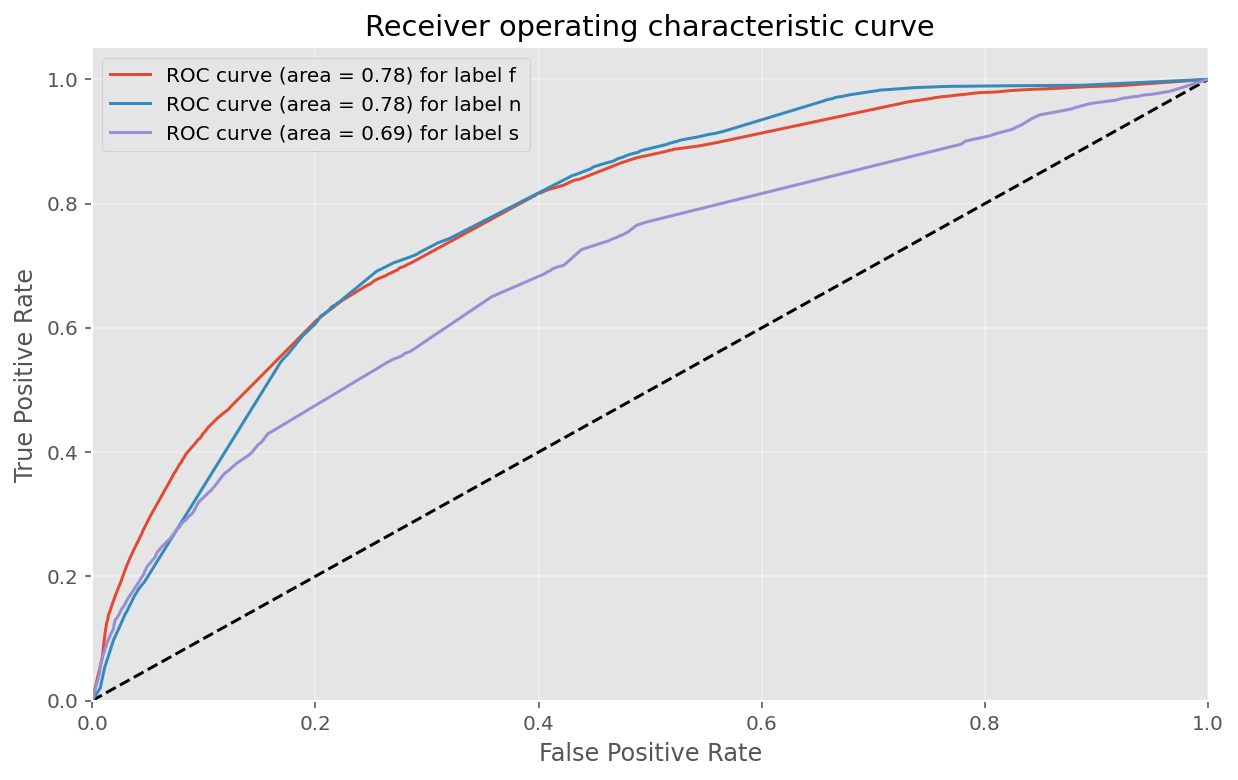

In [121]:
plot_multiclass_roc(best_dt, X_test_processed, y_test, 3, figsize = (10, 6))

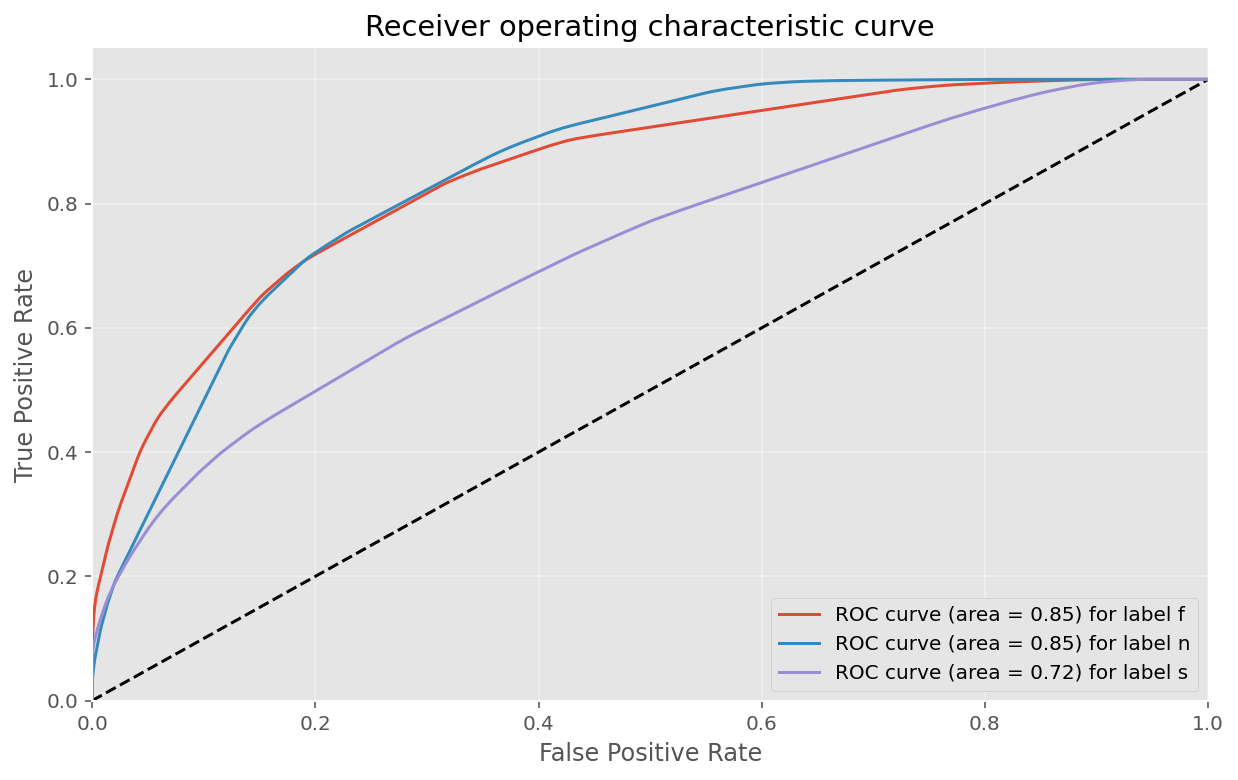

In [150]:
plot_multiclass_roc(best_dt, X_train_processed, y_train, 3, figsize = (10, 6))

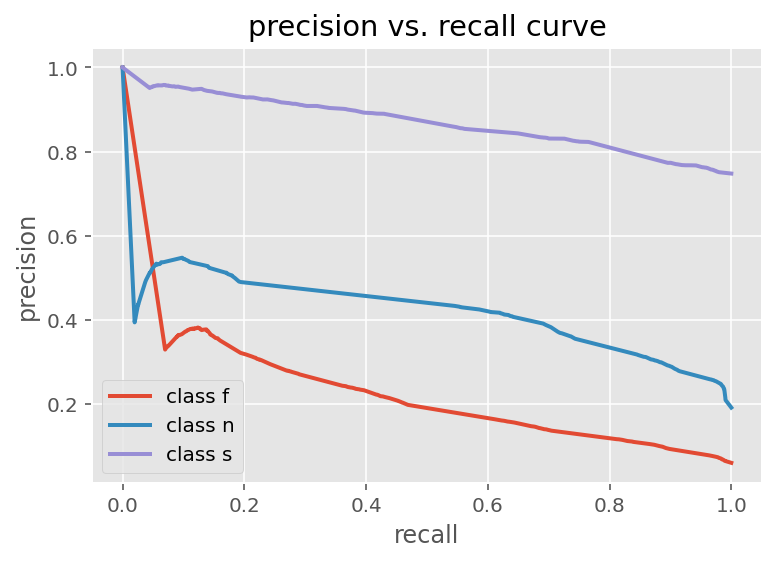

In [140]:
multiclass_precision_recall(best_dt, X_test_processed, y_test)

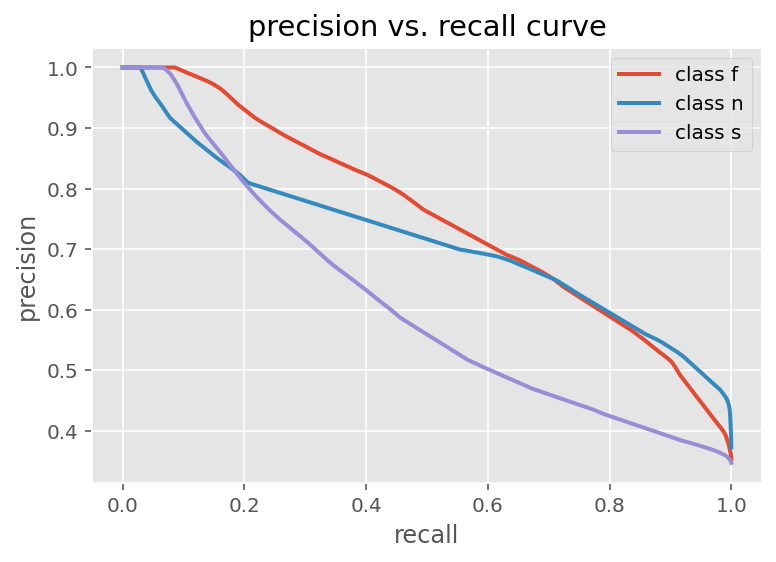

In [151]:
multiclass_precision_recall(best_dt, X_train_processed, y_train)

In [135]:
dt_feature_df = pd.DataFrame({'importances': best_dt.feature_importances_}, index = X_train_processed.columns)
dt_feature_df.sort_values('importances', ascending = False).head(20)

,importances
year,0.178706
conditions__schizophrenia borderline,0.125953
categories__x5_n,0.059866
categories__x4_n,0.056668
categories__x0_infec,0.042829
categories__x0_skin,0.032847
categories__x3_direct,0.032818
categories__x3_indirect,0.020124
categories__x1_female,0.017105
targets__sodium dependent,0.015080


<AxesSubplot:>

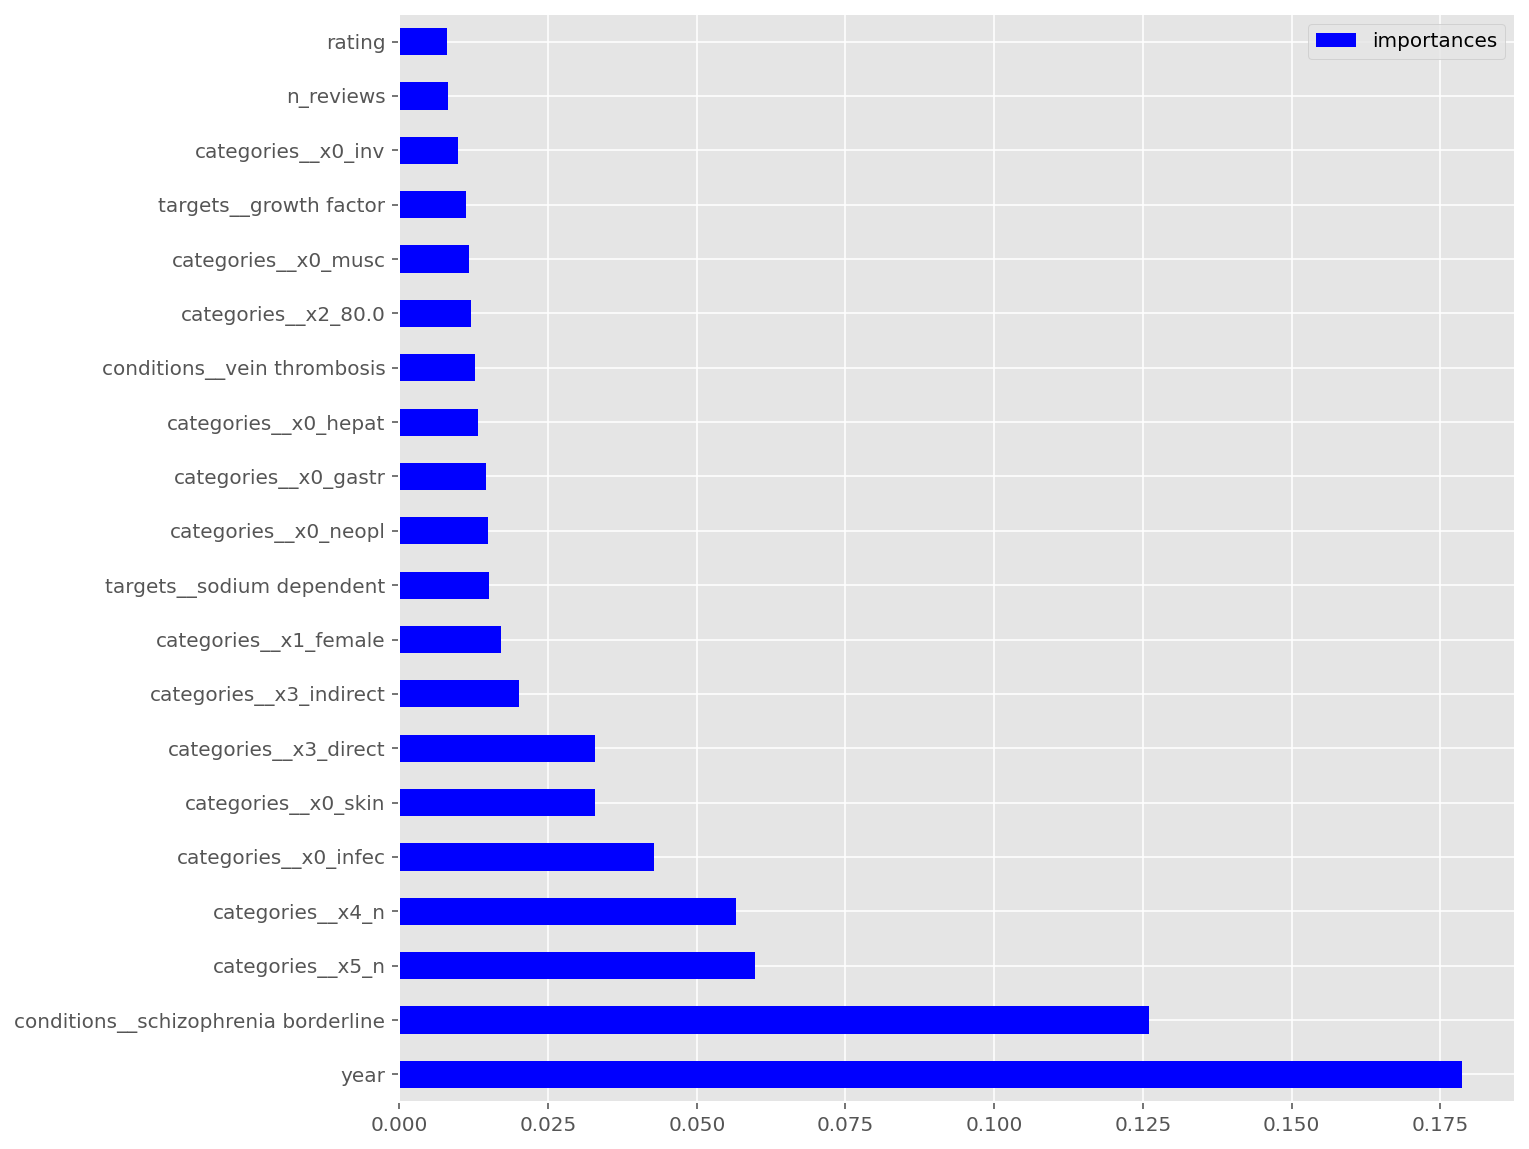

In [136]:
dt_feature_df.sort_values('importances', ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [56]:
# AdaBoost max depth 3

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [58]:
base_estimator = DecisionTreeClassifier(max_depth=3, max_features=0.3)
ada = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1)
ada.fit(X_train_processed, y_train)

print(ada.score(X_train_processed, y_train))
print(cross_val_score(ada, X_train_processed, y_train, cv=5).mean())
print(ada.score(X_test_processed, y_test))

0.6996829587374922
0.694996089811205
0.5436497988856098


In [61]:
joblib.dump(ada, 'ada.jlib')

['ada.jlib']

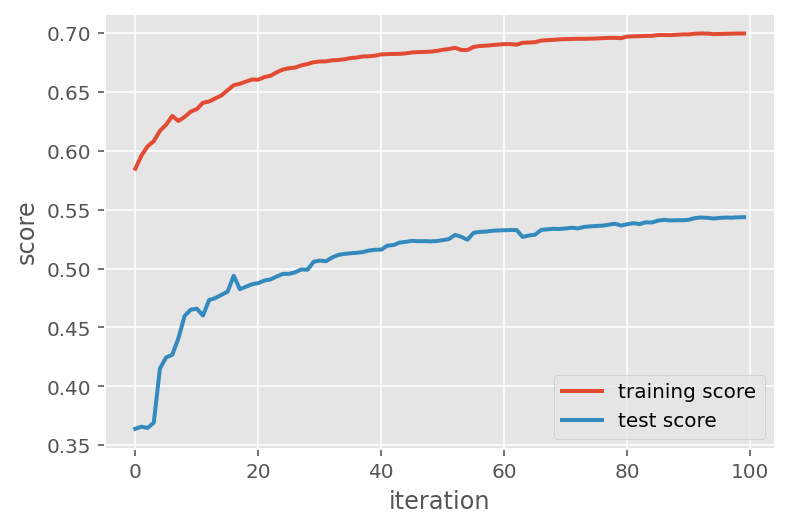

In [60]:
plt.plot(list(ada.staged_score(X_train_processed, y_train)),
         label='training score', lw=2)
plt.plot(list(ada.staged_score(X_test_processed, y_test)), label='test score', lw=2)
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           f       0.78      0.73      0.75     91237
           n       0.87      0.72      0.79    102542
           s       0.45      0.63      0.52     60762

    accuracy                           0.70    254541
   macro avg       0.70      0.69      0.69    254541
weighted avg       0.74      0.70      0.71    254541



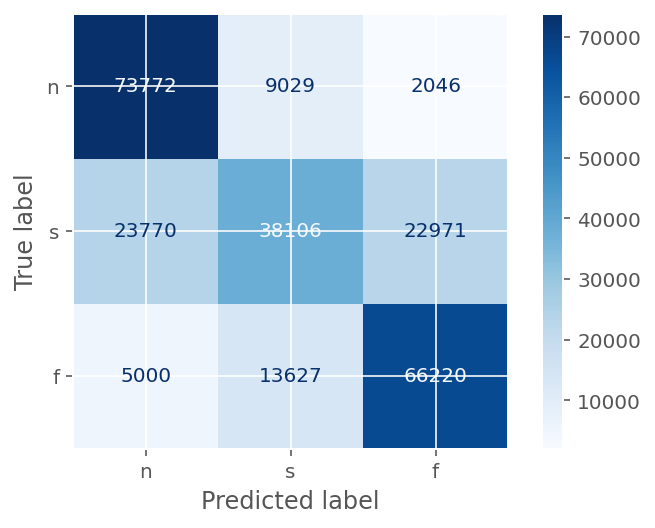

In [142]:
print(classification_report(ada.predict(X_train_processed), y_train))
plot_confusion_matrix(ada, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

              precision    recall  f1-score   support

           f       0.78      0.18      0.29     90749
           n       0.87      0.44      0.58    133372
           s       0.44      0.92      0.60    126923

    accuracy                           0.54    351044
   macro avg       0.69      0.51      0.49    351044
weighted avg       0.69      0.54      0.51    351044



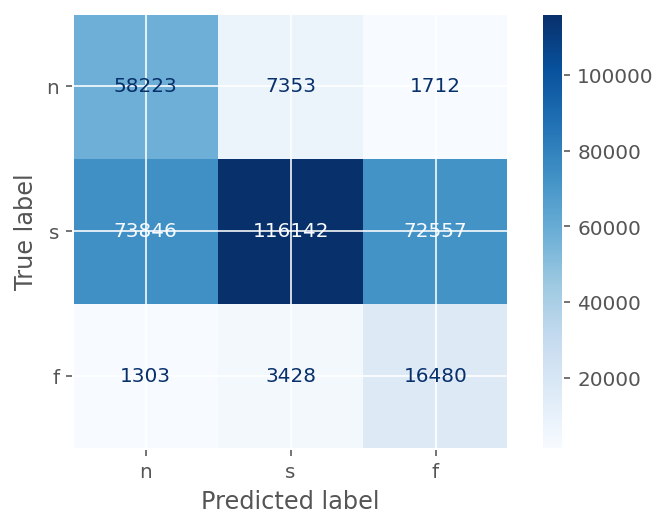

In [143]:
print(classification_report(ada.predict(X_test_processed), y_test))
plot_confusion_matrix(ada, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

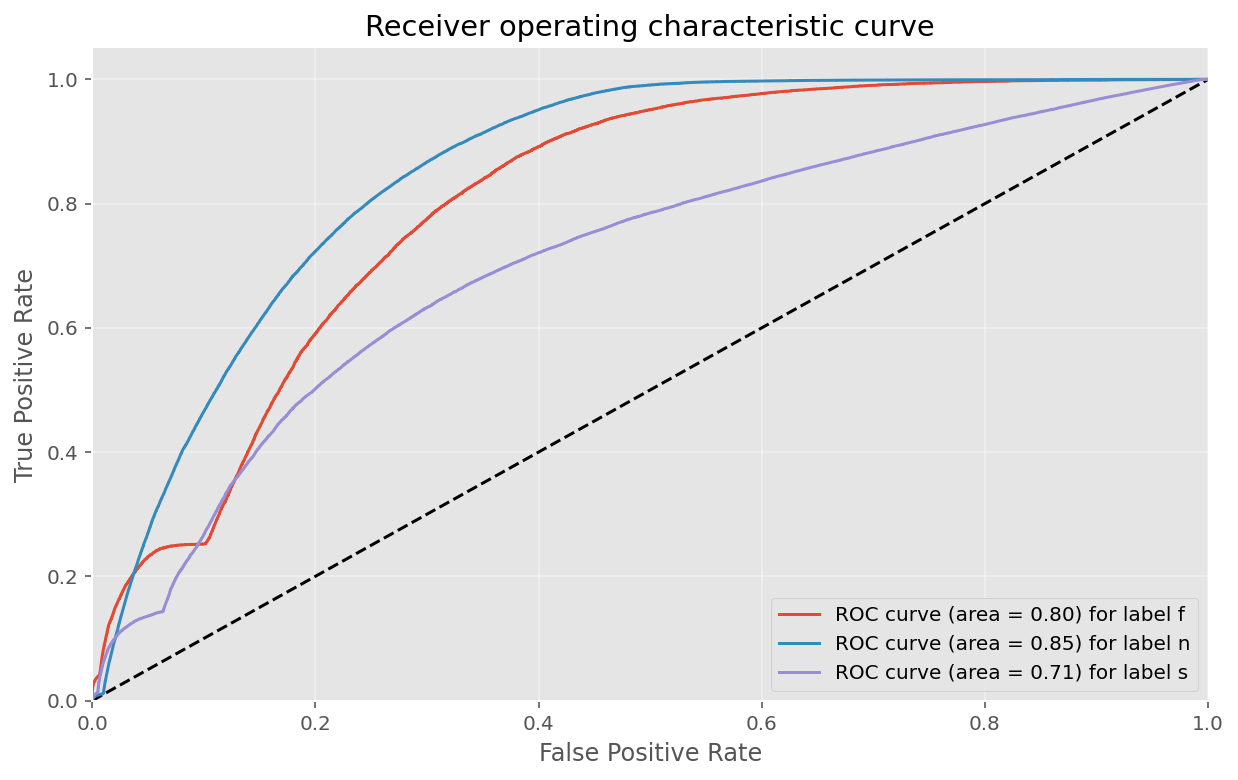

In [144]:
plot_multiclass_roc(ada, X_test_processed, y_test, 3, figsize = (10, 6))

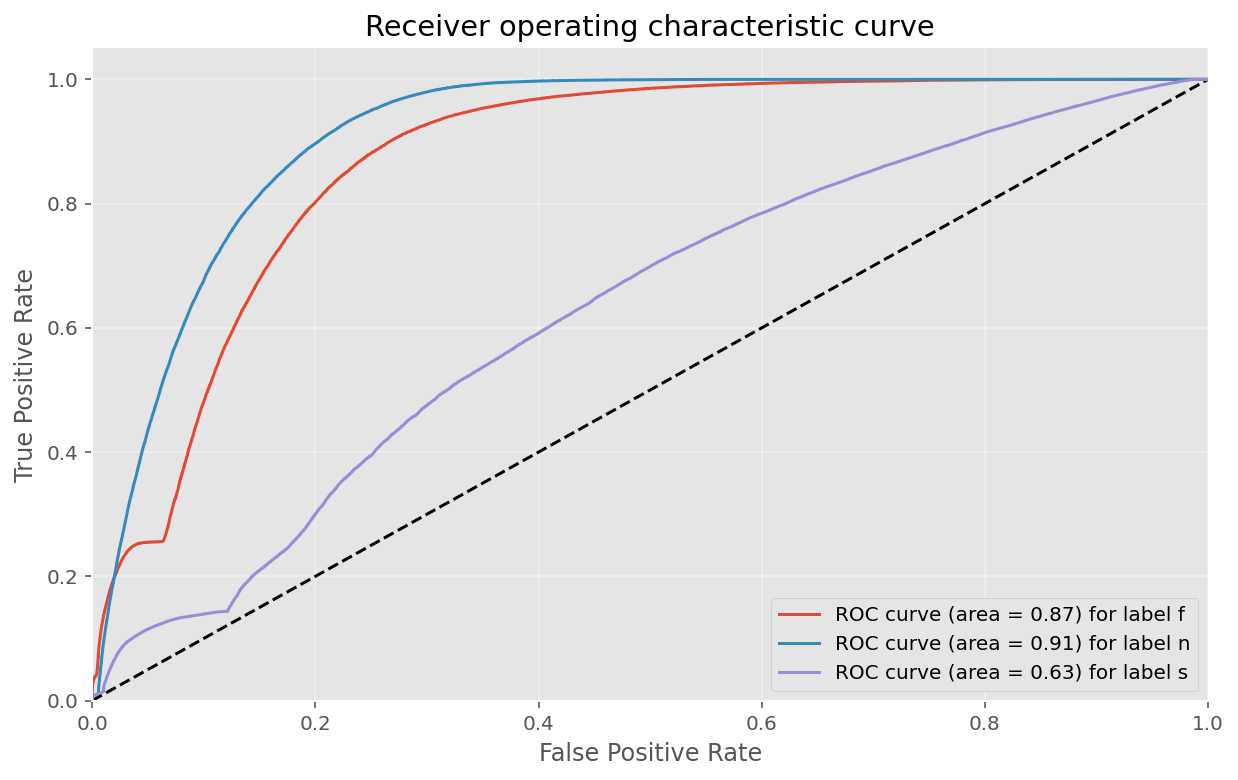

In [152]:
plot_multiclass_roc(ada, X_train_processed, y_train, 3, figsize = (10, 6))

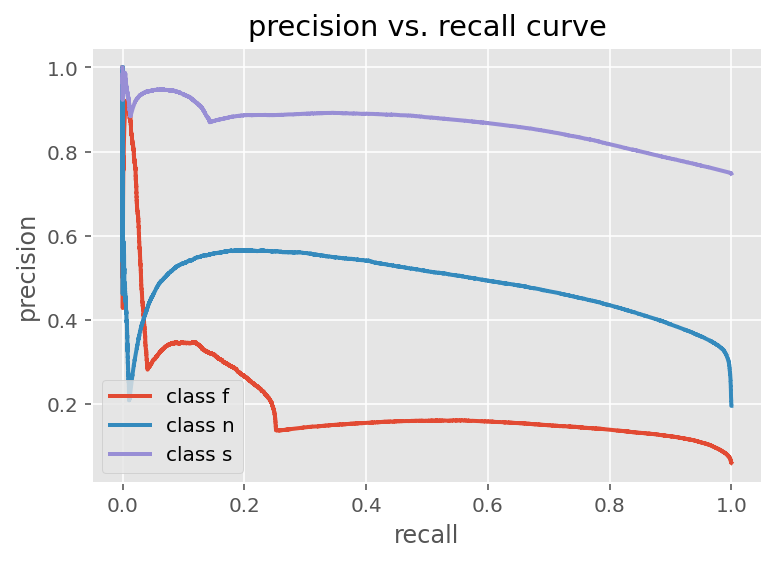

In [145]:
multiclass_precision_recall(ada, X_test_processed, y_test)

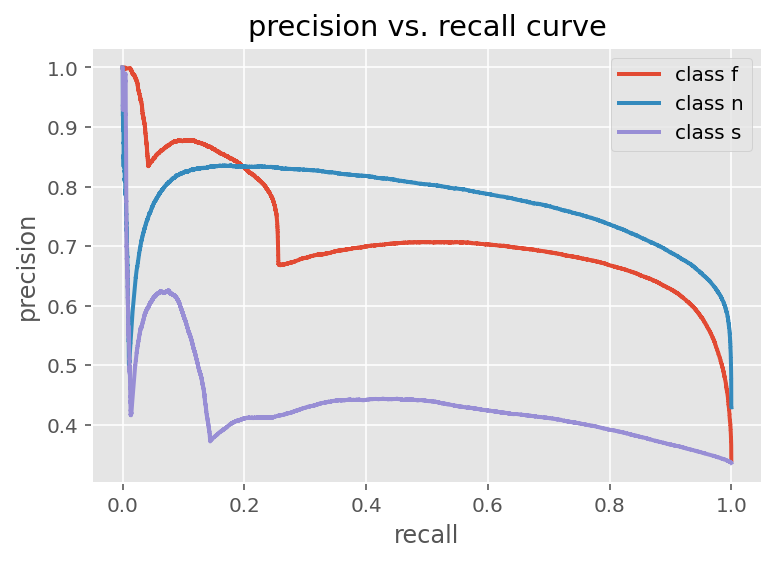

In [153]:
multiclass_precision_recall(ada, X_train_processed, y_train)

In [146]:
ada_feature_df = pd.DataFrame({'importances': ada.feature_importances_}, index = X_train_processed.columns)
ada_feature_df.sort_values('importances', ascending = False).head(20)

,importances
year,0.073983
categories__x3_indirect,0.026694
n_reviews,0.017208
rating,0.016826
categories__x5_y,0.016072
categories__x3_direct,0.013958
categories__x0_skin,0.013204
categories__x4_n,0.012984
categories__x2_80.0,0.012689
categories__x4_y,0.010603


<AxesSubplot:>

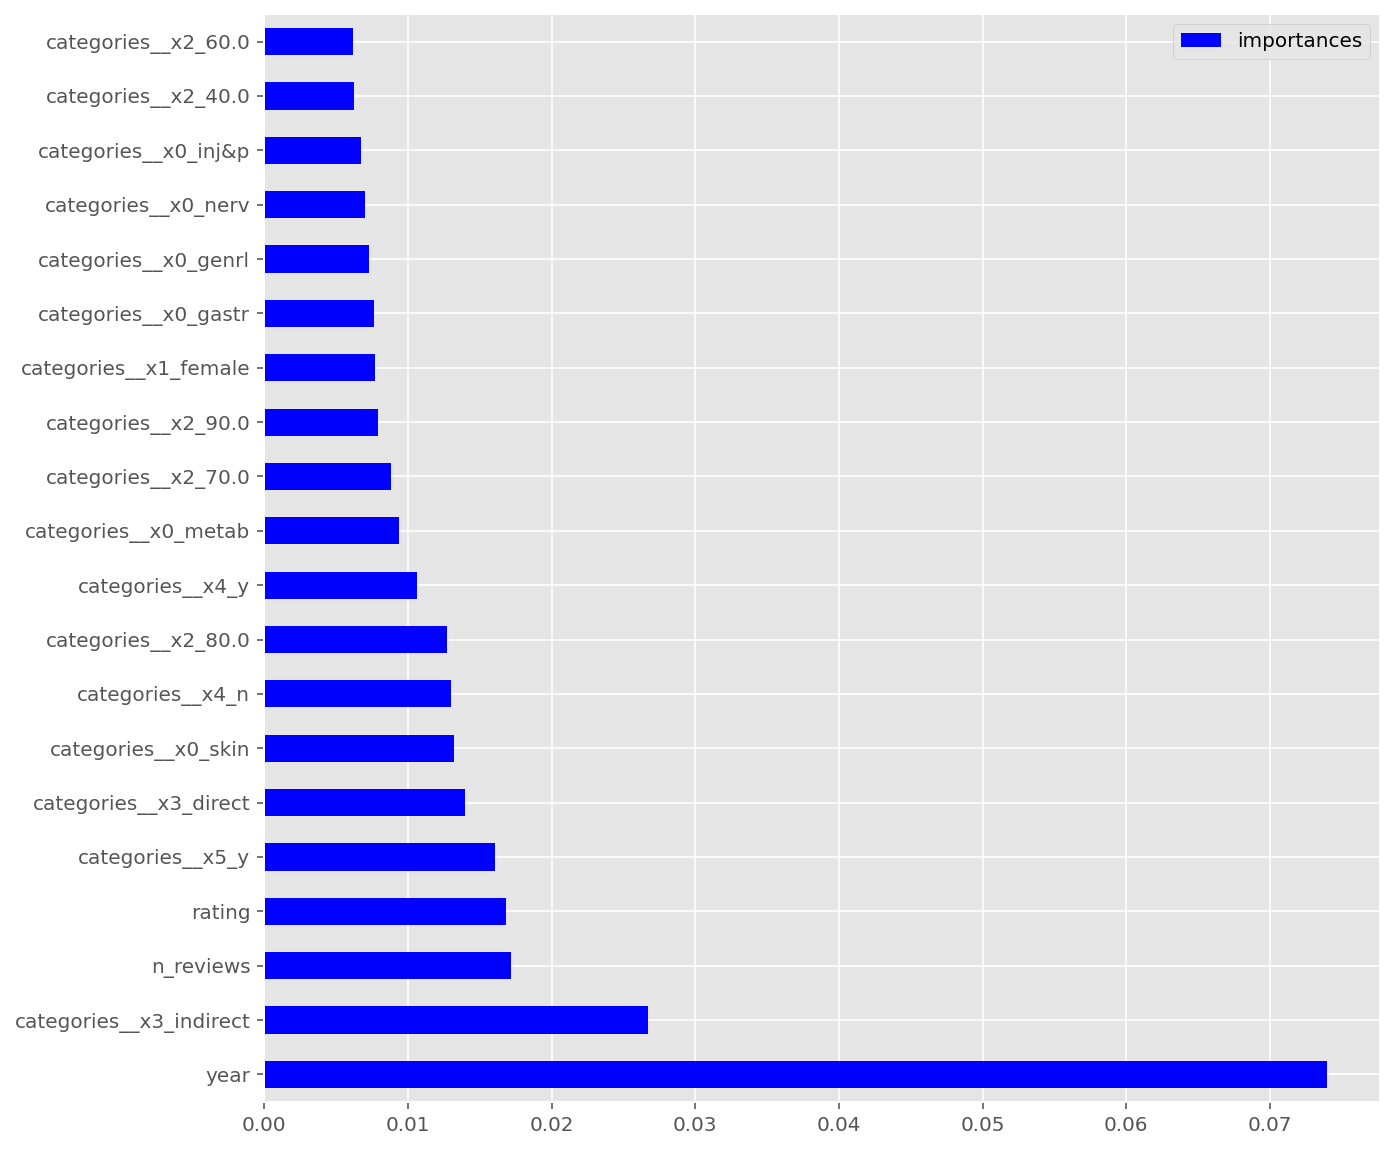

In [147]:
ada_feature_df.sort_values('importances', ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [64]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [67]:
hb = HistGradientBoostingClassifier(max_depth = 3)

hb.fit(X_train_processed, y_train)
hb_scores = cross_val_score(hb, X_train_processed, y_train, cv=5)

print(hb_scores.mean())
print(ada.score(X_train_processed, y_train))
print(ada.score(X_test_processed, y_test))

0.6820355043293593
0.6996829587374922
0.5436497988856098


In [68]:
joblib.dump(hb, 'histboost.joblib')

['histboost.joblib']

In [69]:
# Naive Bayes
from sklearn import naive_bayes

In [73]:
nb = naive_bayes.MultinomialNB()

alphas = {'alpha': np.linspace(0.0001, 1.0, 10)}
nb_grid = GridSearchCV(nb, alphas, cv = 5, n_jobs = 2, verbose = 3)
nb_grid.fit(X_train_processed, y_train)

print(nb_grid.best_score_)
print(nb_grid.best_params_)
best_nb = nb_grid.best_estimator_
print(best_nb.score(X_train_processed, y_train))
print(best_nb.score(X_test_processed, y_test))
# nb_scores = cross_val_score(nb, X_train_processed, y_train, cv=5)
# print(nb_scores.mean())
# print(nb.score(X_train_processed, y_train))
# print(nb.score(X_test_processed, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 13.1min finished


0.615983283958914
{'alpha': 0.0001}
0.6165490038932824
0.4564698442360502


              precision    recall  f1-score   support

           f       0.67      0.66      0.67     85757
           n       0.83      0.62      0.71    112693
           s       0.35      0.53      0.42     56091

    accuracy                           0.62    254541
   macro avg       0.62      0.61      0.60    254541
weighted avg       0.67      0.62      0.63    254541



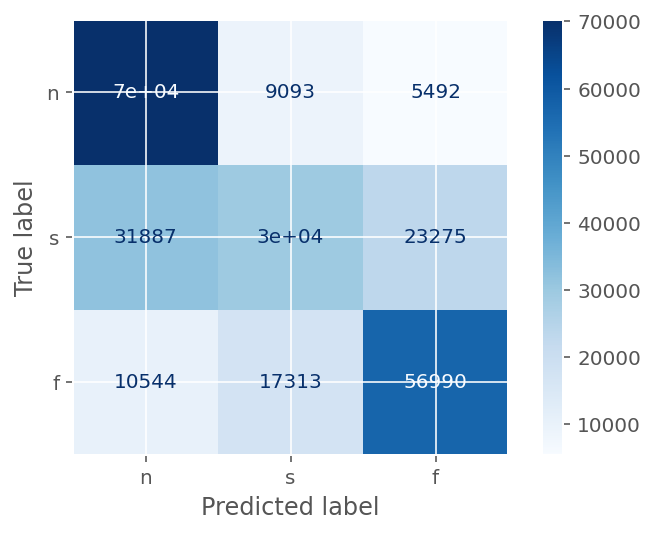

In [154]:
print(classification_report(best_nb.predict(X_train_processed), y_train))
plot_confusion_matrix(best_nb, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

              precision    recall  f1-score   support

           f       0.67      0.16      0.25     91318
           n       0.83      0.35      0.50    157999
           s       0.34      0.89      0.50    101727

    accuracy                           0.46    351044
   macro avg       0.61      0.47      0.41    351044
weighted avg       0.65      0.46      0.43    351044



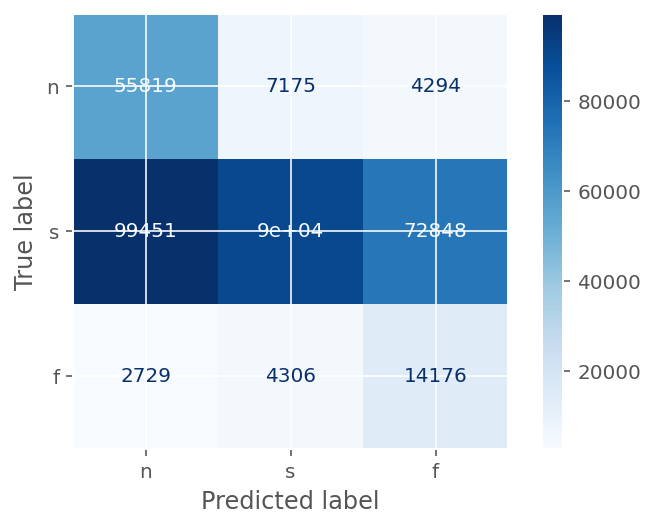

In [155]:
print(classification_report(best_nb.predict(X_test_processed), y_test))
plot_confusion_matrix(best_nb, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

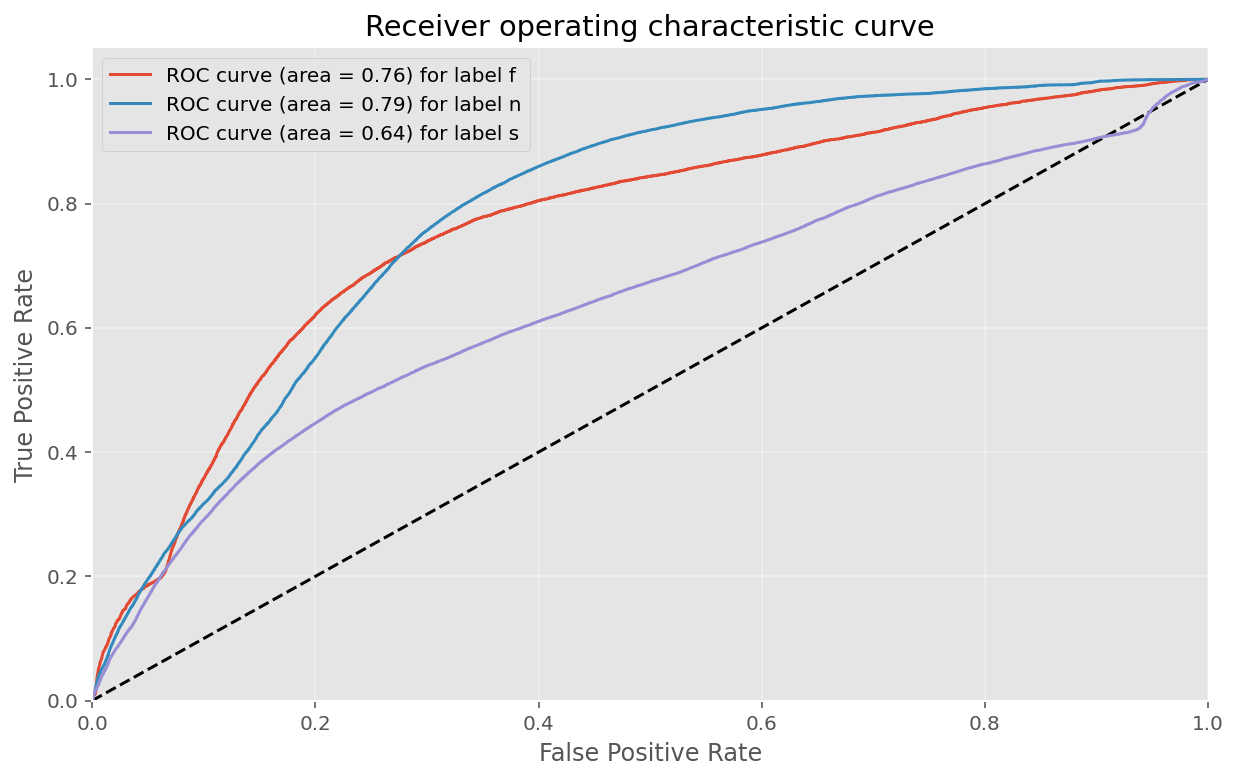

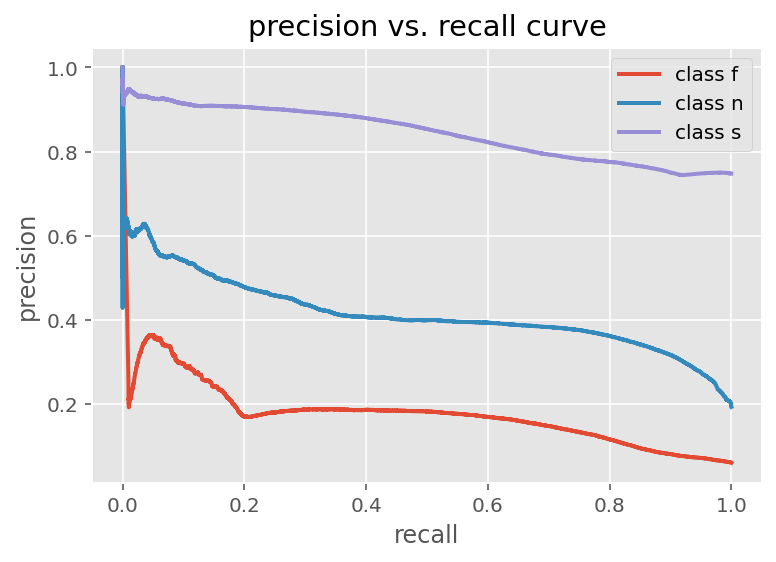

In [156]:
plot_multiclass_roc(best_nb, X_test_processed, y_test, 3, figsize = (10, 6))
multiclass_precision_recall(best_nb, X_test_processed, y_test)

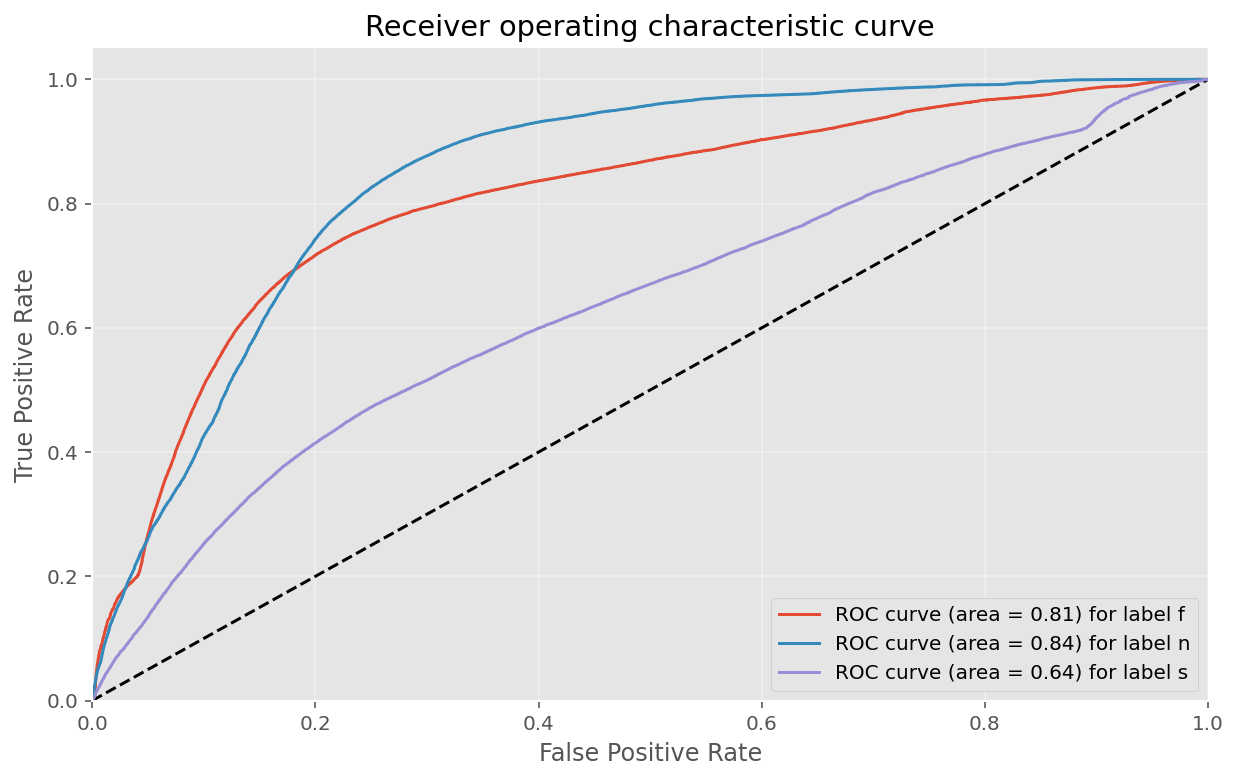

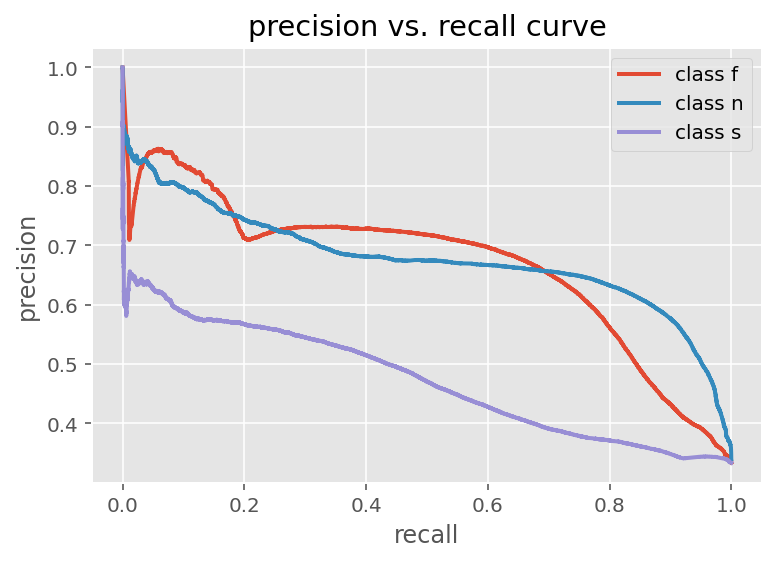

In [157]:
plot_multiclass_roc(best_nb, X_train_processed, y_train, 3, figsize = (10, 6))
multiclass_precision_recall(best_nb, X_train_processed, y_train)

In [161]:
best_nb.classes_

array(['f', 'n', 's'], dtype='<U1')

In [176]:
np.exp(best_nb.feature_log_prob_[0])

array([0.001522  , 0.00401149, 0.00012511, ..., 0.03676564, 0.03242343,
       0.00125983])

In [177]:
nb_feature_df = pd.DataFrame({'class_f': np.exp(best_nb.feature_log_prob_[0]),
                              'class_n': np.exp(best_nb.feature_log_prob_[1]),
                              'class_s': np.exp(best_nb.feature_log_prob_[2])},
                             index = X_train_processed.columns)
nb_feature_df.head()

,class_f,class_n,class_s
categories__x0_blood,0.001522,0.000006,0.001298
categories__x0_card,0.004011,0.000544,0.001292
categories__x0_cong,0.000125,0.000003,0.000149
categories__x0_ear,0.000032,0.000437,0.000266
categories__x0_endo,0.000101,0.000024,0.000144


<AxesSubplot:>

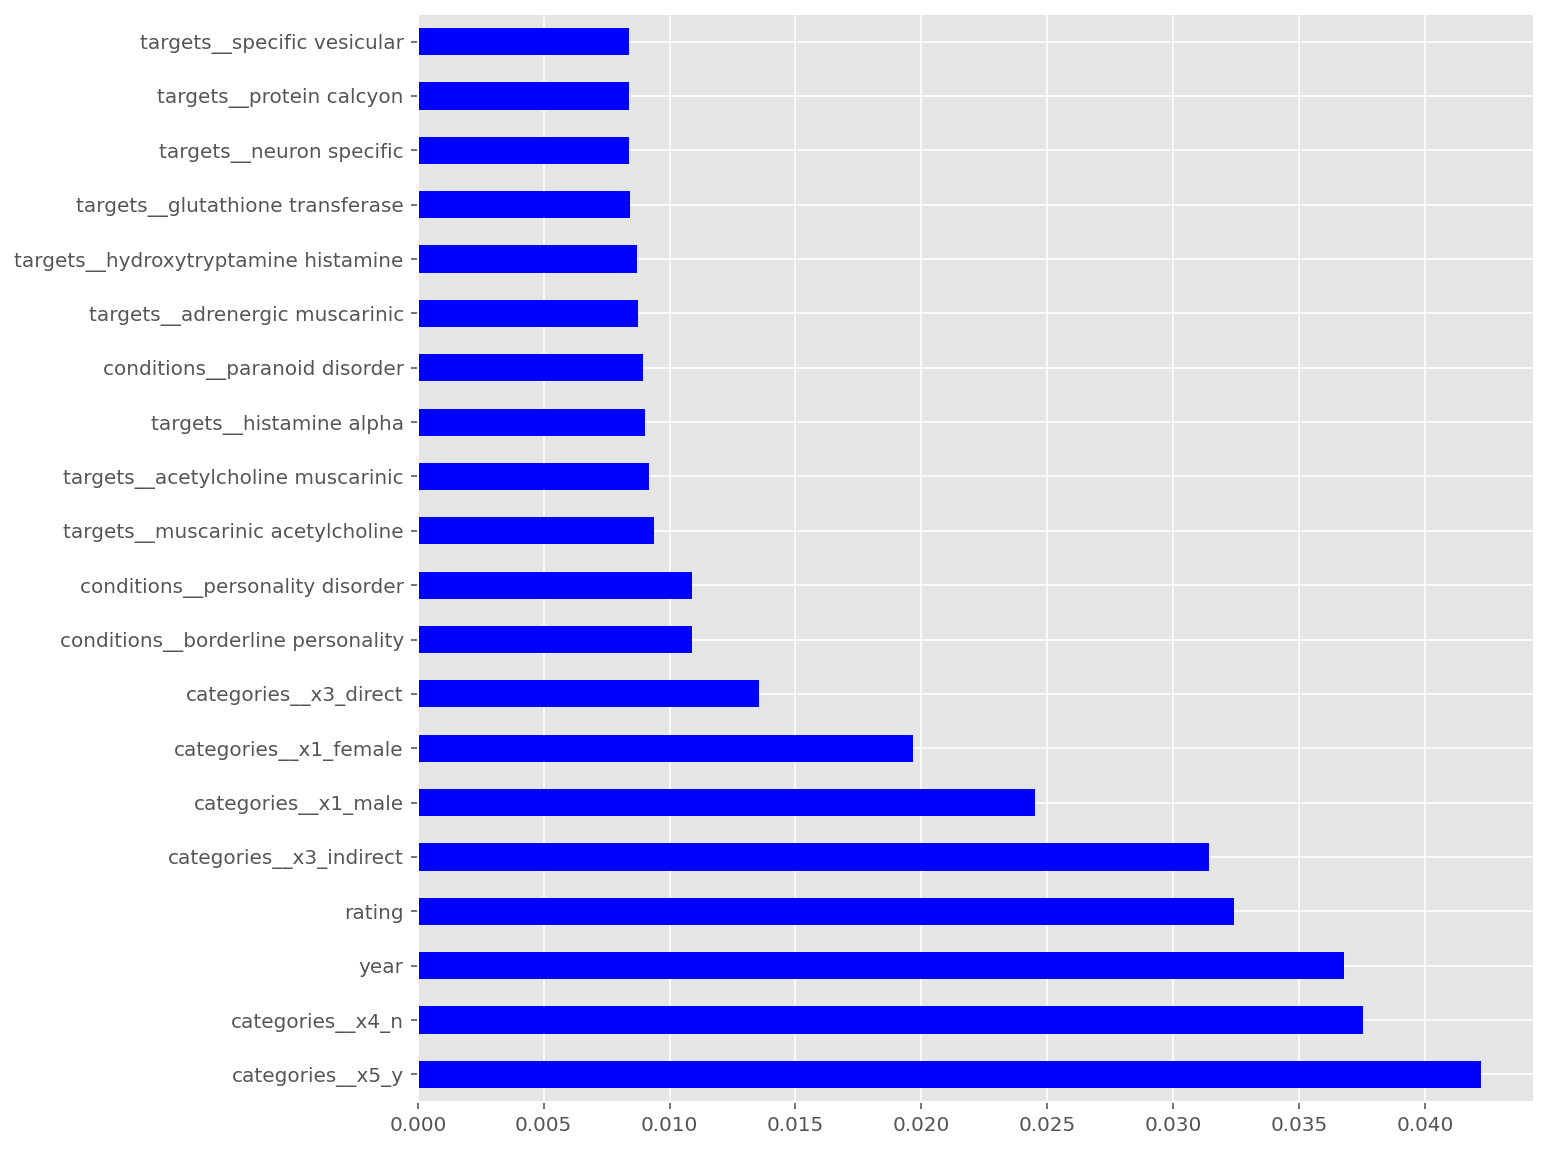

In [178]:
nb_feature_df['class_f'].sort_values(ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

<AxesSubplot:>

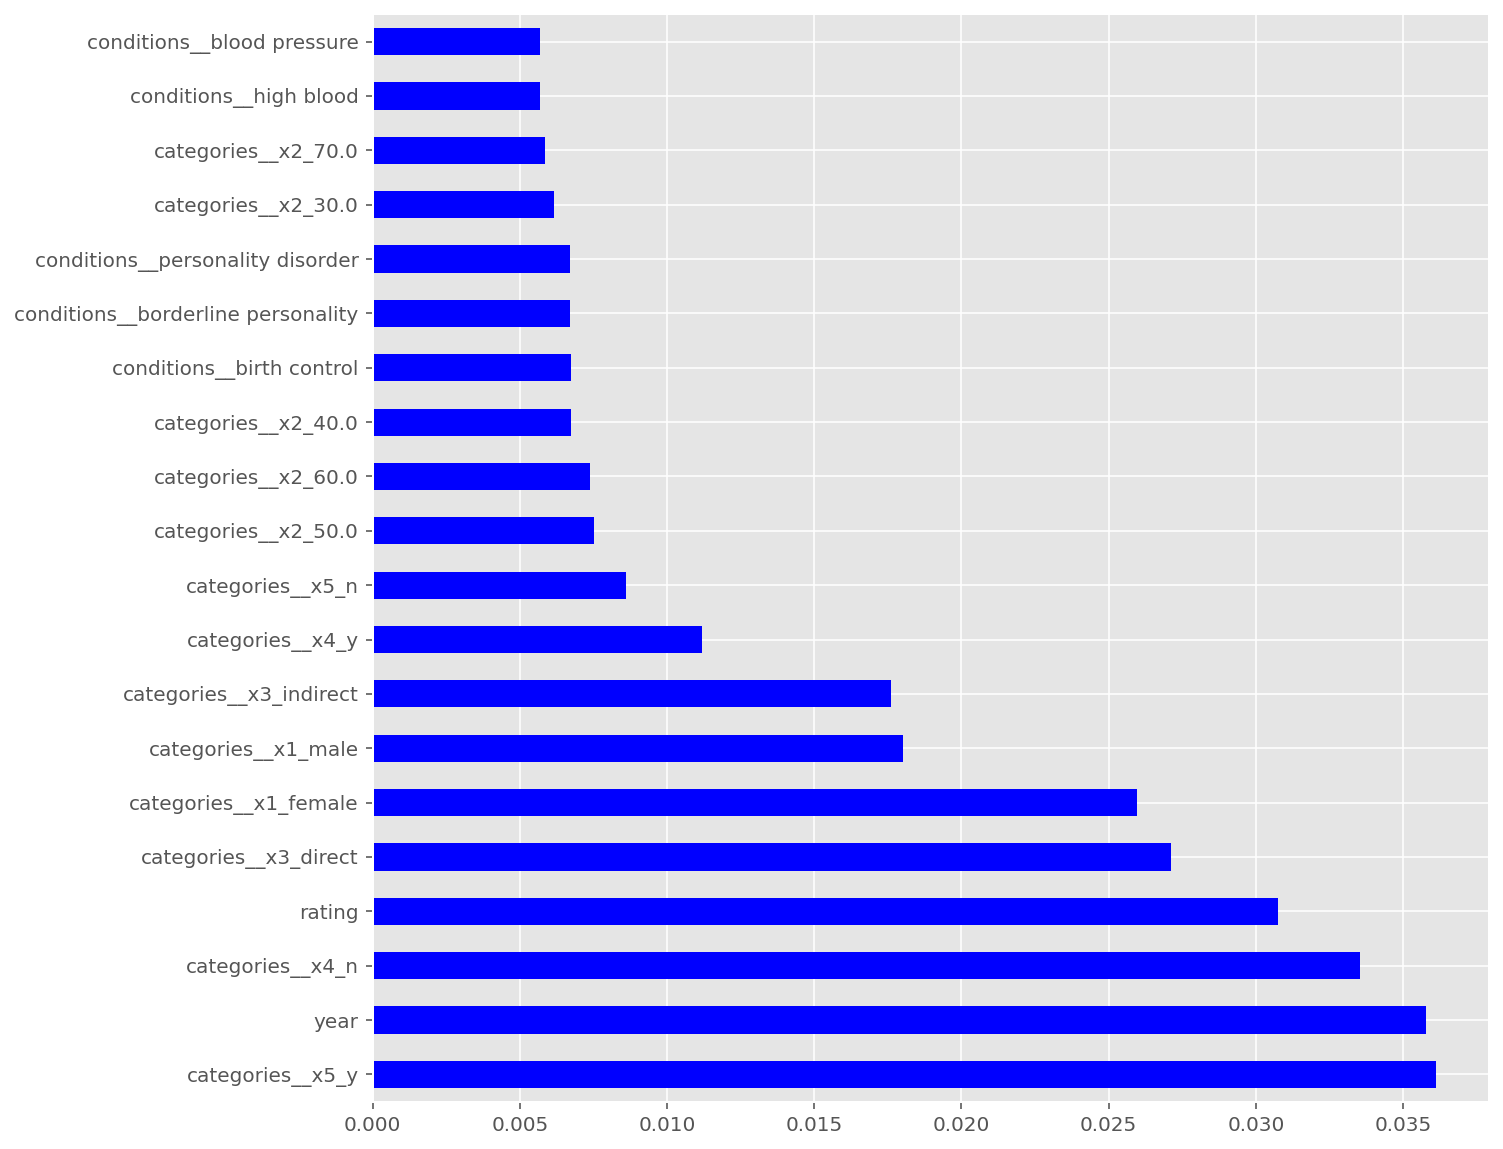

In [179]:
nb_feature_df['class_s'].sort_values(ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

<AxesSubplot:>

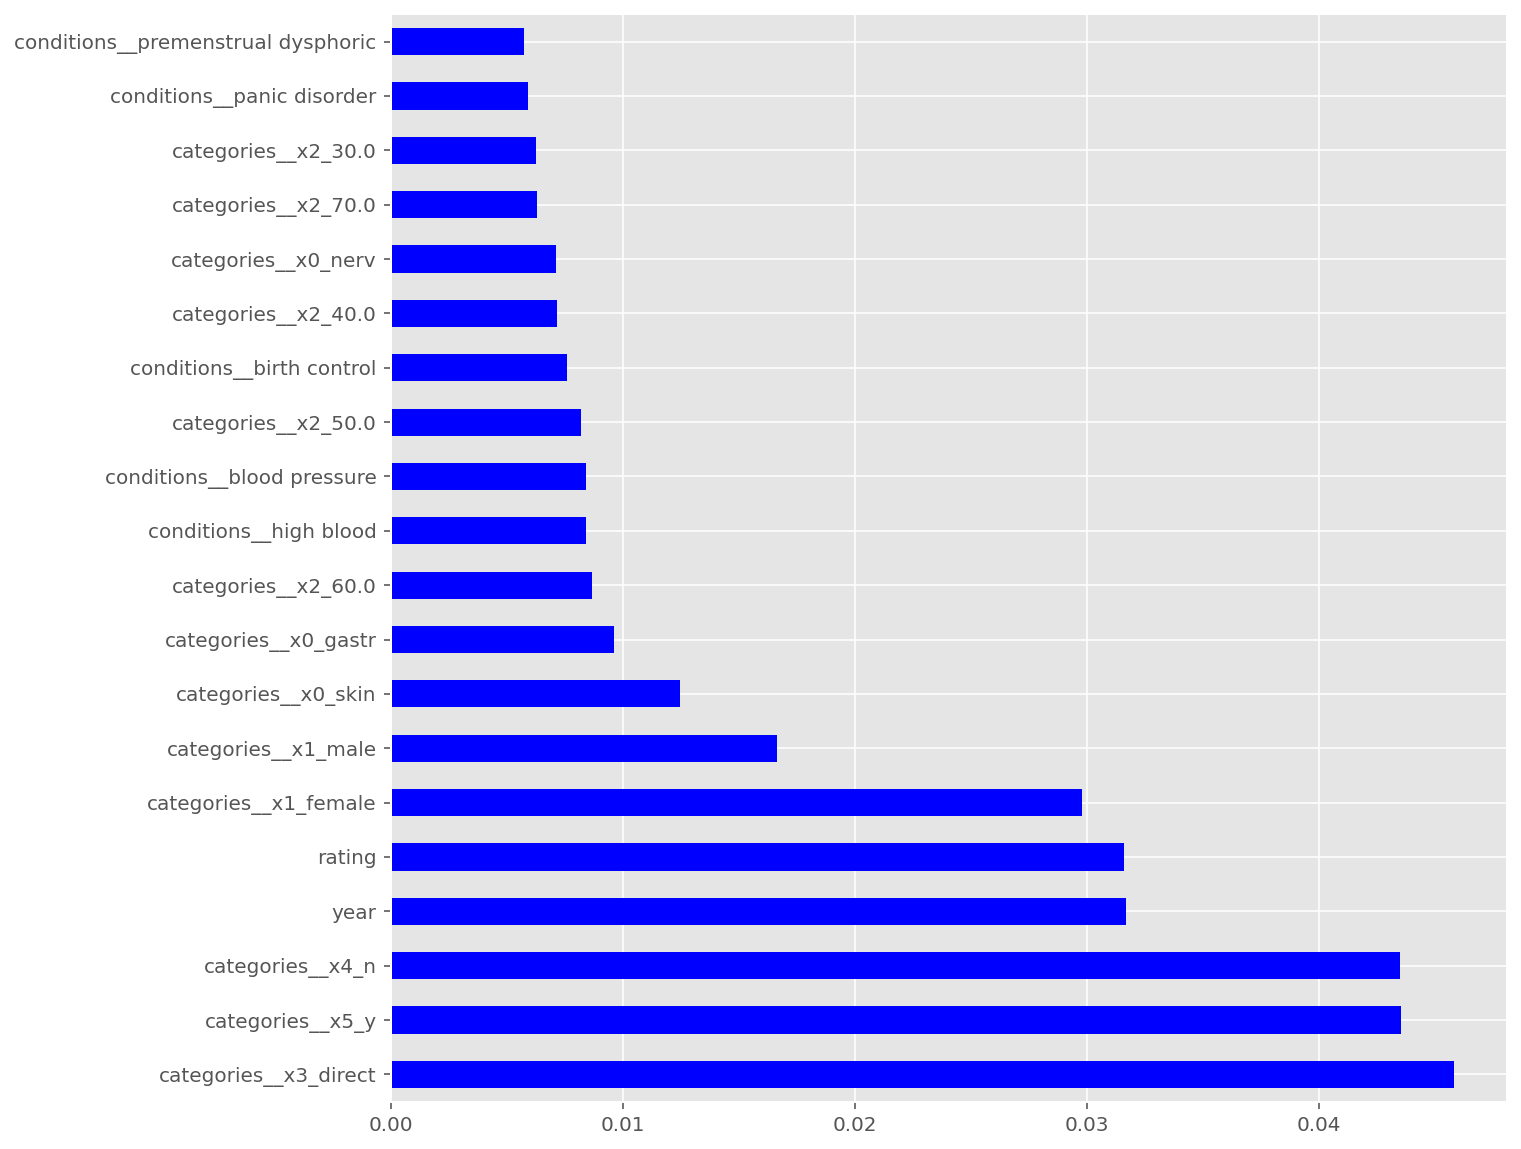

In [180]:
nb_feature_df['class_n'].sort_values(ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [75]:
# SVC
from sklearn.svm import SVC

In [79]:
svc = SVC()
params = {'kernel': ['rbf', 'sigmoid'],
          'C': np.logspace(-4, 2, 10),
          'gamma': ['scale', 'auto']}

svc_grid = GridSearchCV(svc, params, cv = 3, verbose = 3, n_jobs = -2)
svc_grid.fit(X_train_processed, y_train)

print(svc_grid.best_params_)
print(svc_grid.best_score_)

best_svc = svc_grid.best_estimator_

print(best_svc.score(X_train_processed, y_train))
print(best_svc.score(X_test_processed, y_test))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [ ]:
joblib.dump(best_svc, 'best_svc.jlib')

In [ ]:
# knn
knn_params = {'n_neighbors': range(3, 303, 50)
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier(max_iteration = 10000)

knn_grid = GridSearchCV(knn, knn_params, n_jobs = -2, cv = 5, verbose = 3)
# fit grid search
knn_grid.fit(X_train_processed, y_train)

# save best estimate
best_knn = knn_gridsearch.best_estimator_

# print best parameters chosen
print('KNN best parameters: ', knn_grid.best_params_)
# print best score (mean cv score)
print('Best Score: ', knn_grid.best_score_)
# print training and test scores
print('Training score: ', knn_grid.score(X_train_processed, y_train))
print('Test score: ', knn_grid.score(X_test_processed, y_test))


In [ ]:
joblib.dump(best_knn, 'best_knn.jlib')
# best_knn = joblib.load('best_knn.jlib')

In [ ]:
# decision tree
with joblib.parallel_backend('dask'):
    decisiontree

In [ ]:
# random forest

In [ ]:
# svm